In [1]:
import json
import random
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from collections import Counter, defaultdict
plt.rcParams["figure.figsize"] = (20, 5)

## Train

In [64]:
record_path = Path("simulation_result/multi/scaling_250_dp_high_value")
num_train_dirs = len(os.listdir(record_path / 'train'))
train_dirs = [record_path / 'train' / f'sim_{i}' for i in range(num_train_dirs)]
config_path = record_path / 'config.json'
print(f"Simulation times: {len(train_dirs)}")

Simulation times: 2


In [65]:
config = (json.loads(config_path.read_text()))
num_agent = sum([agent_config['number'] for agent_config in config['Agent']['RLAgent']])
agent_number = 250

In [66]:
import json

train_markets, train_agents, train_rl_states, train_lengths, train_timesteps = [], [], [], [], []
for _dir in train_dirs:
    security_path = _dir / "TSMC.json"
    agent_path = _dir / "agent.json"
    rl_path = _dir / 'rl_agent.json'
    config_path = _dir / 'config.json'
    market = json.loads(security_path.read_text())
    train_markets.append(market)
    train_agents.append(json.loads(agent_path.read_text()))
    train_rl_states.append(json.loads(rl_path.read_text()))
    train_lengths.append(len(market['price']))
    train_timesteps.append([i for i in range(len(market['price']))])


In [67]:
markets = train_markets
agents = train_agents
rl_states = train_rl_states
lengths = train_lengths
timesteps = train_timesteps
print(f"Average training length: {sum(lengths) / len(lengths)}")

Average training length: 800.0


### Price & Value

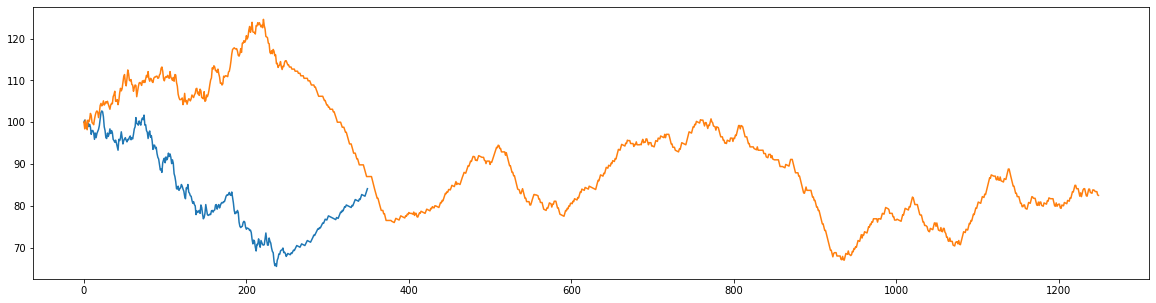

In [68]:
for market in markets:
    plt.plot(market['price'])

In [ ]:
# Average price & value
avg_prices, avg_values = [], []
for market in markets:
    avg_prices.append(sum(market['price']) / len(market['price']))
    avg_values.append(sum(market['value']) / len(market['value']))

plt.plot(avg_prices, label = 'Price')
plt.plot(avg_values, label = 'Value')
plt.legend()

### Bid & Ask

In [ ]:
avg_bids, avg_asks = [], []
for market in markets:
    avg_bids.append(sum(market['bid']) / len(market['bid']))
    avg_asks.append(sum(market['ask']) / len(market['ask']))

plt.plot(avg_bids, label = 'Bid')
plt.plot(avg_asks, label = 'Ask')
plt.legend()
plt.show()
print(f"Average step per bid quantity per agent: {1 / (sum([sum(market['bid']) / len(market['bid']) for market in markets]) / len(markets) / num_agent)}")
print(f"Average step per ask quantity per agent: {1 / (sum([sum(market['ask']) / len(market['ask']) for market in markets]) / len(markets) / num_agent)}")

In [ ]:
# # train
# for market in markets:
#     plt.plot(market['price'], label = 'price')
#     plt.plot(market['value'], label = 'value')
#     plt.legend()
#     plt.show()


In [ ]:
# for market in markets:
#     plt.plot(market['bid'], label = 'Bid quantity')
#     plt.plot(market['ask'], label = 'Ask quantity')
#     plt.legend()
#     plt.show()

### Agent returns

#### Distribution of total returns 

In [ ]:
agent_state['states'][-1]

In [ ]:
all_agent_returns = []
for rl_state in rl_states:
    for agent_state in rl_state.values():
        returns = (agent_state['states'][-1]['agent_state']['wealth'] - agent_state['states'][0]['agent_state']['wealth']) / agent_state['states'][0]['agent_state']['wealth']
        all_agent_returns.append(round(returns * 100))

In [ ]:
num_pos_returns = len([ret for ret in all_agent_returns if ret > 0])
num_neg_returns = len([ret for ret in all_agent_returns if ret < 0])

In [ ]:
num_pos_returns = len([ret for ret in all_agent_returns if ret > 0])
num_neg_returns = len([ret for ret in all_agent_returns if ret < 0])
agent_returns_counter = Counter(all_agent_returns)
returns_x = sorted(agent_returns_counter.keys())
returns_y = [agent_returns_counter[x] for x in returns_x]
plt.scatter(returns_x, returns_y)
print(f"Rate of positive returns: {num_pos_returns / (num_pos_returns + num_neg_returns)}")
print(f"Rate of negtive returns: {num_neg_returns / (num_pos_returns + num_neg_returns)}")

#### Distribution of returns by agent

In [ ]:
agent_ids = rl_states[0].keys()
agent_returns = {agent_id: [] for agent_id in agent_ids}

for rl_state in rl_states:
    for agent_id, agent_state in rl_state.items():
        returns = (agent_state['states'][-1]['agent_state']['wealth'] - agent_state['states'][0]['agent_state']['wealth']) / agent_state['states'][0]['agent_state']['wealth']
        agent_returns[agent_id].append(round(returns * 100, 2))

In [ ]:
avg_agent_returns = [round(sum(agent_return) / len(agent_return)) for agent_return in agent_returns.values()]
agent_returns_counter = Counter(avg_agent_returns)
returns_x = sorted(agent_returns_counter.keys())
returns_y = [agent_returns_counter[x] for x in returns_x]
plt.scatter(returns_x, returns_y)

In [ ]:
plt.figure(figsize=(40, 10))
returns_progress = [returns[-1] - returns[0] for returns in agent_returns.values()]
plt.scatter(list(range(len(returns_progress))), returns_progress)
num_pos_progress = len([progress for progress in returns_progress if progress > 0])
num_neg_progress = len([progress for progress in returns_progress if progress < 0])
print(f"Positive progress: {num_pos_progress / len(returns_progress)}")
print(f"Negative progress: {num_neg_progress / len(returns_progress)}")


### Total loss & reward

In [ ]:
# Agent average loss
total_policy_loss = {}
total_value_loss = {}
length = len(markets[0]['price'][250:])
for agent_id in agent_ids:
    agent_policy_losses = []
    agent_value_losses = []
    for states in rl_states:
        agent_policy_loss = sum(states[agent_id]['policy_loss'])
        agent_value_loss = sum(states[agent_id]['value_loss'])
        agent_policy_losses.append(agent_policy_loss)
        agent_value_losses.append(agent_value_loss)
    total_policy_loss[agent_id] = agent_policy_losses
    total_value_loss[agent_id] = agent_value_losses

avg_policy_loss = [sum([total_policy_loss[agent_id][i] for agent_id in agent_ids]) / len(agent_ids) for i in range(len(rl_states))]
avg_value_loss = [sum([total_value_loss[agent_id][i] for agent_id in agent_ids]) / len(agent_ids) for i in range(len(rl_states))]
plt.plot(avg_policy_loss)
plt.show()
plt.plot(avg_value_loss)


In [ ]:
if isinstance(states[agent_id]['rewards'][0], list):
    for i, states in enumerate(rl_states):
        reward = [reward for reward in states[agent_id]['rewards']]
        plt.plot(reward, label = f"sim_{i}")
    plt.legend()
    plt.title('Reward')
    plt.show()
    
else:
    for i, states in enumerate(rl_states):
        weighted_reward = [reward['weighted_reward'] for reward in states[agent_id]['rewards']]
        plt.plot(weighted_reward, label = f"sim_{i}")
    plt.legend()
    plt.title('Weighted reward')
    plt.show()

    for i, states in enumerate(rl_states):
        wealth_reward = [reward['wealth_reward'] for reward in states[agent_id]['rewards']]
        plt.plot(wealth_reward, label = f"sim_{i}")
    plt.legend()
    plt.title('Wealth reward')
    plt.show()


    for i, states in enumerate(rl_states):
        action_reward = [reward['action_reward'] for reward in states[agent_id]['rewards']]
        plt.plot(action_reward, label = f"sim_{i}")

    plt.legend()
    plt.title('Action reward')
    plt.show()

    for i, states in enumerate(rl_states):
        action_reward = [reward['strategy_reward'] for reward in states[agent_id]['rewards']]
        plt.plot(action_reward, label = f"sim_{i}")

    plt.legend()
    plt.title('Strategy reward')
    plt.show()
    
    for i, states in enumerate(rl_states):
        total_reward, wealth_reward, action_reward, strategy_reward = [], [], [], []
        
        for reward in states[agent_id]['rewards']:
            total_reward.append(reward['weighted_reward'])
            wealth_reward.append(reward['wealth_reward'])
            action_reward.append(reward['action_reward'])
            strategy_reward.append(reward['strategy_reward'])
            if reward['action_reward'] != 0:
                print(reward)
                break

        for label, value in zip(['Total', 'Wealth', 'Action', 'Strategy'], [total_reward, wealth_reward, action_reward, strategy_reward]):
            plt.plot(value, label = label)
        plt.legend()
        plt.show()

### Sample agent

#### Value

In [ ]:
# sample agent to analyse
value_group_name = "ppo_va_1"
value_agent_number = 250
value_agent_id = f"{value_group_name}_{random.randint(0, 0)}"
rl_state = rl_states[-1]
market = markets[-1]
tick_size = 0.1
agent_id = value_agent_id


In [ ]:
# Holdings
for i, rl_state in enumerate(rl_states):
    agent_state = rl_state[agent_id]['states']
    cash = [state['cash'] for state in agent_state]
    holding = [state['TSMC'] for state in agent_state]
    wealth = [state['wealth'] for state in agent_state]
    plt.plot(wealth, label = f"sim_{i}")
    plt.title('Wealth')
    plt.legend()


In [ ]:
# Holdings
agent_state = rl_states[-1][agent_id]['states']
cash = [state['cash'] for state in agent_state]
holding = [state['TSMC'] for state in agent_state]
wealth = [state['wealth'] for state in agent_state]
plt.plot(cash, label = "Cash")
plt.plot(wealth, label = "Wealth")
plt.legend()
plt.show()
plt.plot(holding, label = "TSMC")
plt.legend()

In [ ]:
# Loss
policy_loss = []
value_loss = []
for i, states in enumerate(rl_states):
    
    policy_loss += states[agent_id]['policy_loss']
    value_loss += states[agent_id]['value_loss']

plt.plot(policy_loss, label = f"Policy loss")
plt.legend()
plt.show()

plt.plot(value_loss, label = f"Value loss")
plt.legend()
plt.show()

In [ ]:
# Rewards
if isinstance(states[agent_id]['rewards'][0], list):
    for i, states in enumerate(rl_states):
        reward = [reward for reward in states[agent_id]['rewards']]
        plt.plot(reward, label = f"sim_{i}")
    plt.legend()
    plt.title('Reward')
    plt.show()
    
else:
    for i, states in enumerate(rl_states):
        weighted_reward = [reward['weighted_reward'] for reward in states[agent_id]['rewards']]
        plt.plot(weighted_reward, label = f"sim_{i}")
    plt.legend()
    plt.title('Weighted reward')
    plt.show()

    for i, states in enumerate(rl_states):
        wealth_reward = [reward['wealth_reward'] for reward in states[agent_id]['rewards']]
        plt.plot(wealth_reward, label = f"sim_{i}")
    plt.legend()
    plt.title('Wealth reward')
    plt.show()


    for i, states in enumerate(rl_states):
        action_reward = [reward['action_reward'] for reward in states[agent_id]['rewards']]
        plt.plot(action_reward, label = f"sim_{i}")

    plt.legend()
    plt.title('Action reward')
    plt.show()

    for i, states in enumerate(rl_states):
        action_reward = [reward['strategy_reward'] for reward in states[agent_id]['rewards']]
        plt.plot(action_reward, label = f"sim_{i}")

    plt.legend()
    plt.title('Strategy reward')
    plt.show()
    
    for i, states in enumerate(rl_states):
        total_reward, wealth_reward, action_reward, strategy_reward = [], [], [], []
        
        for reward in states[agent_id]['rewards']:
            total_reward.append(reward['weighted_reward'])
            wealth_reward.append(reward['wealth_reward'])
            action_reward.append(reward['action_reward'])
            strategy_reward.append(reward['strategy_reward'])
            if reward['action_reward'] != 0:
                print(reward)
                break

        for label, value in zip(['Total', 'Wealth', 'Action', 'Strategy'], [total_reward, wealth_reward, action_reward, strategy_reward]):
            plt.plot(value, label = label)
        plt.legend()
        plt.show()

In [ ]:
# sample agent to analyse
value_group_name = "ppo_va_1"
value_agent_number = 1
value_agent_id = f"{value_group_name}_{random.randint(0, 0)}"
rl_state = rl_states[-1]
market = markets[-1]
tick_size = 0.1
agent_id = value_agent_id

action_ref = {0: "BID", 1: "ASK", 2: "HOLD"}
tick_ref = {i: tick for i, tick in zip(list(range(0, 9)), list(range(-4, 5)))}
print(agent_id)
for state, market in zip(rl_states, markets):
    orders = []
    counter = {"BID": 0, "ASK": 0, "HOLD": 0}
    for i, action in enumerate(state[agent_id]['actions']):
        bid_or_ask = action_ref[action[0]]
        ticks = 1
        price = market['price'][249+i] + tick_size * ticks
        volume = 1
        order = {'time': i, "bid_or_ask": bid_or_ask, "price": price, "volume": volume}
        counter[bid_or_ask] += 1
        orders.append(order)

    total_actions = sum(counter.values())
    print(counter)
    print(f"Bid: {counter['BID'] / total_actions}\nAsk: {counter['ASK'] / total_actions}\nHold: {counter['HOLD'] / total_actions}")
    bid_x, bid_y = [], []
    ask_x, ask_y = [], []
    bid_sizes, ask_sizes = [], []
    bid_colors, ask_colors = [], []
    base_size = 10
    for i, order in enumerate(orders):
        if order['bid_or_ask'] == 'BID':
    #         if order['time'] > 5000 and order['time'] < 5100:
            bid_x.append(order['time'])
            bid_y.append(order['price'])
            bid_colors.append('r')
            bid_sizes.append(base_size * order['volume'])
        if order['bid_or_ask'] == 'ASK':
    #         if order['time'] > 5000 and order['time'] < 5100:
            ask_x.append(order['time'])
            ask_y.append(order['price'])
            ask_colors.append('g')  
            ask_sizes.append(base_size * order['volume'])
    plot_price = market['price'][250:]
    plot_value = market['value'][250:]
    x = np.arange(len(plot_price))
    plt.figure(figsize=(80, 20))
    plt.plot(x, plot_price, label = "price")
    plt.plot(x, plot_value, label = "value")
    plt.legend()
    plt.scatter(bid_x, bid_y, s = bid_sizes, c = bid_colors, marker = 6)
    plt.scatter(ask_x, ask_y, s = ask_sizes, c = ask_colors, marker = 7)
    plt.show()
    
    total_reward, wealth_reward, action_reward, strategy_reward = [], [], [], []

    for reward in state[agent_id]['rewards']:
        total_reward.append(reward['weighted_reward'])
        wealth_reward.append(reward['wealth_reward'])
        action_reward.append(reward['action_reward'])
        strategy_reward.append(reward['strategy_reward'])
        if reward['action_reward'] != 0:
            print(reward)
            break

    for label, value in zip(['Total', 'Wealth', 'Action', 'Strategy'], [total_reward, wealth_reward, action_reward, strategy_reward]):
        plt.plot(value, label = label)
    plt.legend()
    plt.show()
#     weighted_reward = [reward['weighted_reward'] for reward in rl_state[agent_id]['rewards']]
#     wealth_reward = [reward['wealth_reward'] for reward in rl_state[agent_id]['rewards']]
#     strategy_reward = [reward['straty'] for reward in rl_state[agent_id]['rewards']]
#     plt.plot(weighted_reward, label = "Total reward")
#     plt.plot(wealth_reward, label = "Wealth reward")
#     plt.plot(strategy_reward, label = "Strategy reward")
#     plt.legend()
#     plt.show()


In [ ]:
for rl_state in rl_states:
    gaps = [state['observations'][0] for state in rl_state[agent_id]['states']]
    prices = [state['observations'][1] for state in rl_state[agent_id]['states']]
    wealths = [state['observations'][2] for state in rl_state[agent_id]['states']]
    actions = [action[0] for action in rl_state[agent_id]['actions']]

    expections = {'Good': 0, 'Bad': 0, 'Hold': 0}
    for gap, action in zip(gaps, actions):
        if gap >= 0:
            if action == 1:
                expections['Good'] += 1
            elif action == 0:
                expections['Bad'] += 1
            else:
                expections['Hold'] += 1
        if gap < 0:
            if action == 0:
                expections['Good'] += 1
            elif action == 1:
                expections['Bad'] += 1
            else:
                expections['Hold'] += 1
    print(f"Good: {expections['Good'] / len(gaps)}, Bad: {expections['Bad'] / len(gaps)}, Hold: {expections['Hold'] / len(gaps)}")

#### Scaling

In [34]:
group_name = f"ppo_sc_{agent_number}"
agent_id = f"{group_name}_{random.randint(0, agent_number - 1)}"
rl_state = rl_states[-1]
market = markets[-1]
tick_size = 0.1


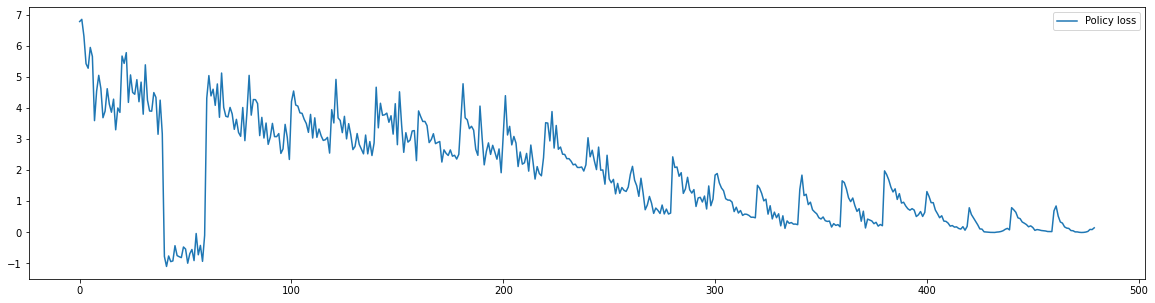

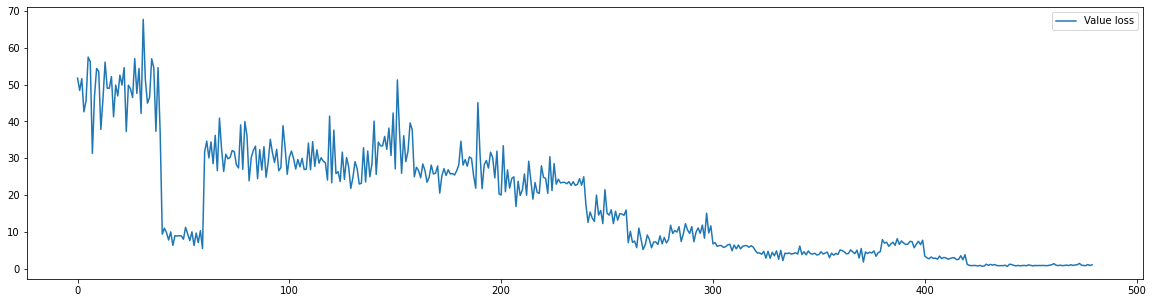

In [35]:
# Loss
policy_loss = []
value_loss = []
for i, states in enumerate(rl_states):
    
    policy_loss += states[agent_id]['policy_loss']
    value_loss += states[agent_id]['value_loss']

plt.plot(policy_loss, label = f"Policy loss")
plt.legend()
plt.show()

plt.plot(value_loss, label = f"Value loss")
plt.legend()
plt.show()

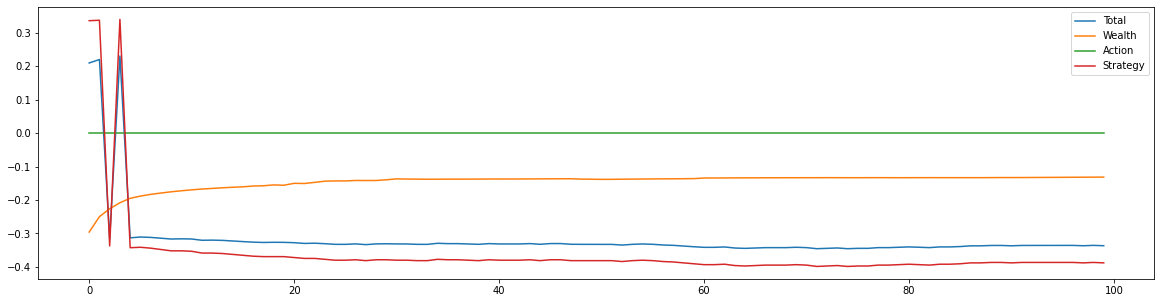

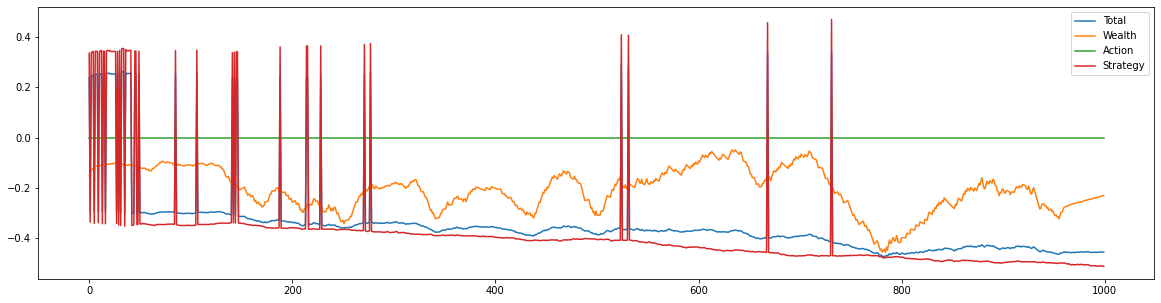

In [36]:
# for i, states in enumerate(rl_states):
#     weighted_reward = [reward['weighted_reward'] for reward in states[agent_id]['rewards']]
#     plt.plot(weighted_reward, label = f"sim_{i}")
# plt.legend()
# plt.title('Weighted reward')
# plt.show()

# for i, states in enumerate(rl_states):
#     wealth_reward = [reward['wealth_reward'] for reward in states[agent_id]['rewards']]
#     plt.plot(wealth_reward, label = f"sim_{i}")
# plt.legend()
# plt.title('Wealth reward')
# plt.show()


# for i, states in enumerate(rl_states):
#     action_reward = [reward['action_reward'] for reward in states[agent_id]['rewards']]
#     plt.plot(action_reward, label = f"sim_{i}")

# plt.legend()
# plt.title('Action reward')
# plt.show()

# for i, states in enumerate(rl_states):
#     action_reward = [reward['strategy_reward'] for reward in states[agent_id]['rewards']]
#     plt.plot(action_reward, label = f"sim_{i}")

# plt.legend()
# plt.title('Strategy reward')
# plt.show()

for i, states in enumerate(rl_states):
    total_reward, wealth_reward, action_reward, strategy_reward = [], [], [], []

    for reward in states[agent_id]['rewards']:
        total_reward.append(reward['weighted_reward'])
        wealth_reward.append(reward['wealth_reward'])
        action_reward.append(reward['action_reward'])
        strategy_reward.append(reward['strategy_reward'])
        if reward['action_reward'] != 0:
            print(reward)
            break

    for label, value in zip(['Total', 'Wealth', 'Action', 'Strategy'], [total_reward, wealth_reward, action_reward, strategy_reward]):
        plt.plot(value, label = label)
    plt.legend()
    plt.show()

ppo_sc_1_0
{'opt': 58, 'pes': 42, 'fud': 0}
opt: 0.58
pes: 0.42
fud: 0.0


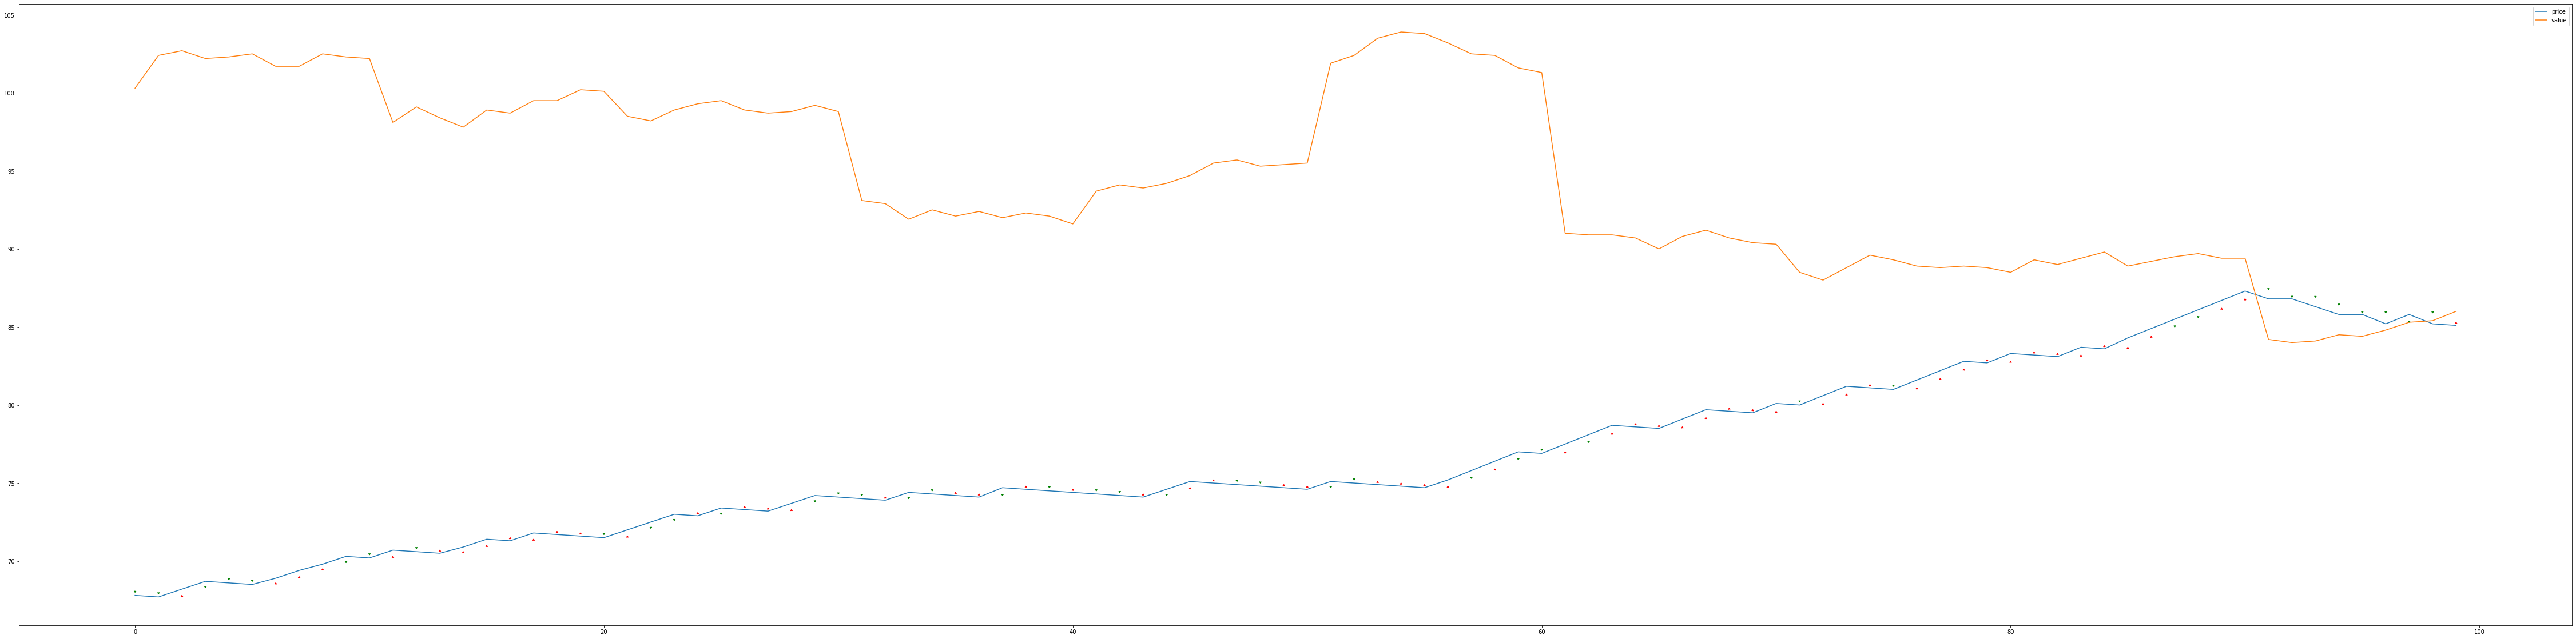

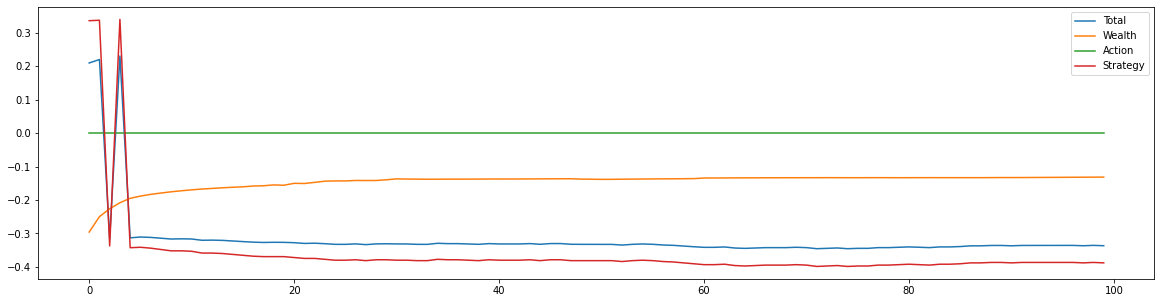

{'opt': 621, 'pes': 367, 'fud': 12}
opt: 0.621
pes: 0.367
fud: 0.012


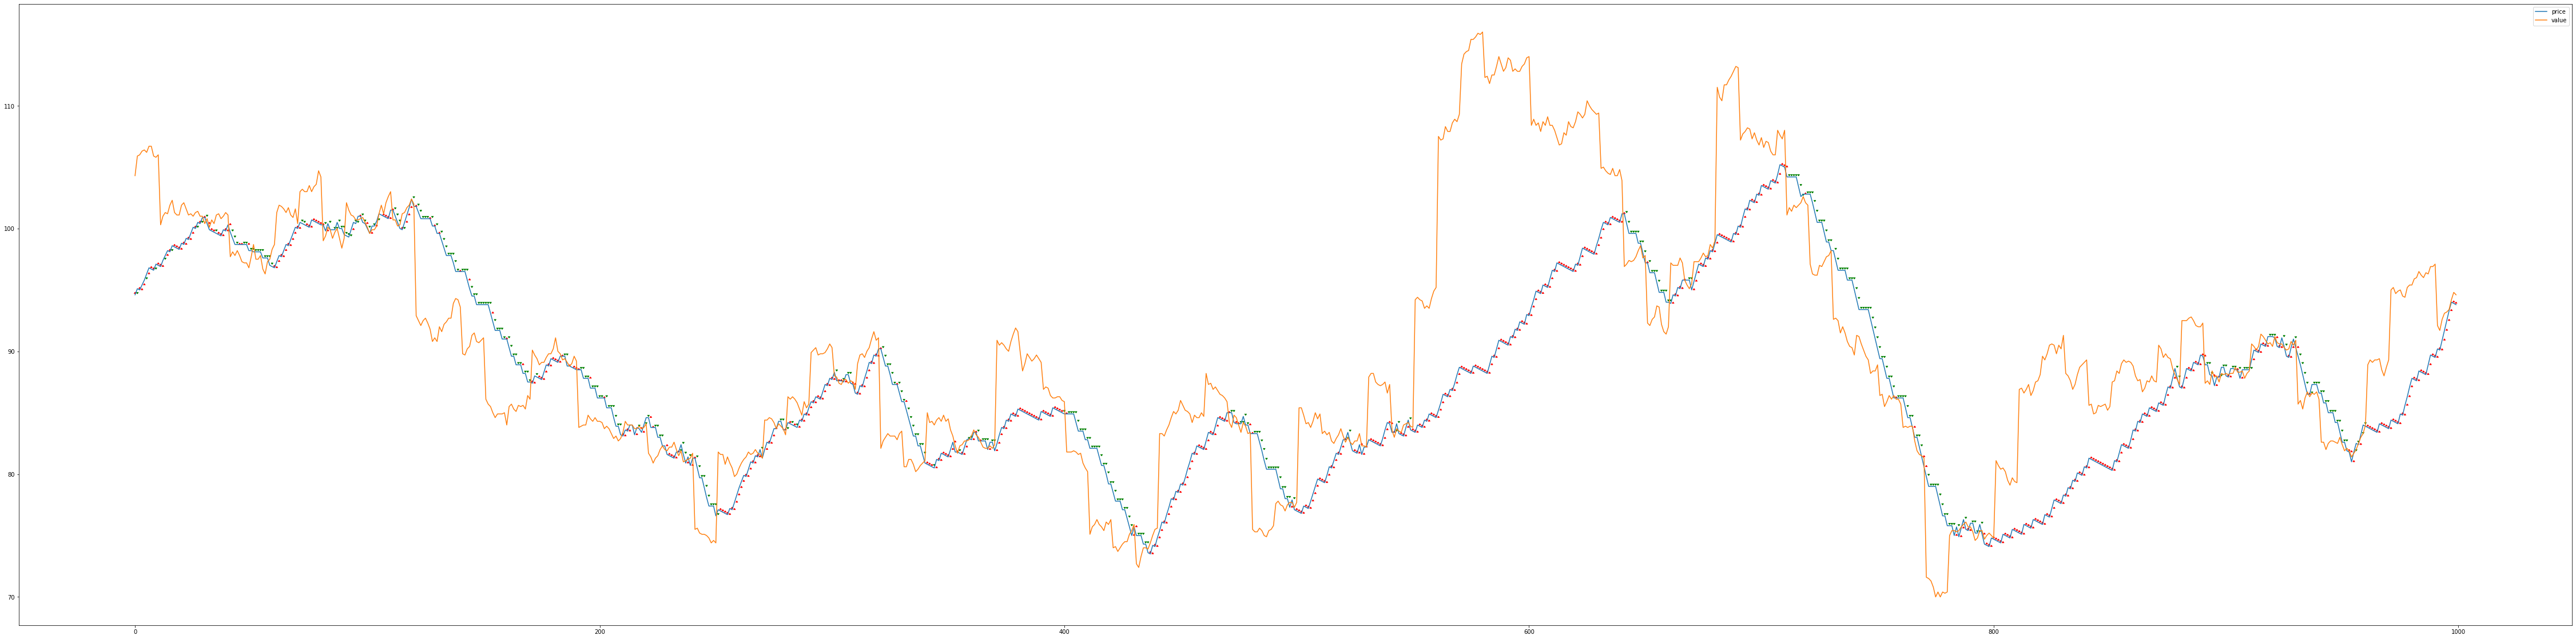

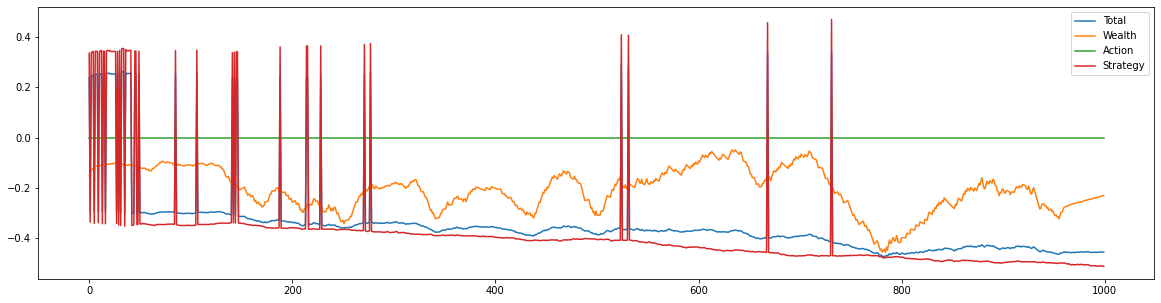

In [37]:
action_ref = {0: "opt", 1: "pes", 2: "fud"}
tick_ref = {i: tick for i, tick in zip(list(range(0, 9)), list(range(-4, 5)))}
print(agent_id)
for state, market in zip(rl_states, markets):
    orders = []
    counter = {"opt": 0, "pes": 0, "fud": 0}
    for i, action in enumerate(state[agent_id]['actions']):
        group = action_ref[action[0]]
        ticks = 1
        price = market['price'][249+i] + tick_size * ticks
        volume = 1
        order = {'time': i, "group": group, "price": price, "volume": volume}
        counter[group] += 1
        orders.append(order)

    total_actions = sum(counter.values())
    print(counter)
    print(f"opt: {counter['opt'] / total_actions}\npes: {counter['pes'] / total_actions}\nfud: {counter['fud'] / total_actions}")
    bid_x, bid_y = [], []
    ask_x, ask_y = [], []
    bid_sizes, ask_sizes = [], []
    bid_colors, ask_colors = [], []
    base_size = 10
    for i, order in enumerate(orders):
        if order['group'] == 'opt':
    #         if order['time'] > 5000 and order['time'] < 5100:
            bid_x.append(order['time'])
            bid_y.append(order['price'])
            bid_colors.append('r')
            bid_sizes.append(base_size * order['volume'])
        if order['group'] == 'pes':
    #         if order['time'] > 5000 and order['time'] < 5100:
            ask_x.append(order['time'])
            ask_y.append(order['price'])
            ask_colors.append('g')  
            ask_sizes.append(base_size * order['volume'])
    plot_price = market['price'][250:]
    plot_value = market['value'][250:]
    x = np.arange(len(plot_price))
    plt.figure(figsize=(80, 20))
    plt.plot(x, plot_price, label = "price")
    plt.plot(x, plot_value, label = "value")
    plt.legend()
    plt.scatter(bid_x, bid_y, s = bid_sizes, c = bid_colors, marker = 6)
    plt.scatter(ask_x, ask_y, s = ask_sizes, c = ask_colors, marker = 7)
    plt.show()
    
    total_reward, wealth_reward, action_reward, strategy_reward = [], [], [], []

    for reward in state[agent_id]['rewards']:
        total_reward.append(reward['weighted_reward'])
        wealth_reward.append(reward['wealth_reward'])
        action_reward.append(reward['action_reward'])
        strategy_reward.append(reward['strategy_reward'])
        if reward['action_reward'] != 0:
            print(reward)
            break

    for label, value in zip(['Total', 'Wealth', 'Action', 'Strategy'], [total_reward, wealth_reward, action_reward, strategy_reward]):
        plt.plot(value, label = label)
    plt.legend()
    plt.show()
#     weighted_reward = [reward['weighted_reward'] for reward in rl_state[agent_id]['rewards']]
#     wealth_reward = [reward['wealth_reward'] for reward in rl_state[agent_id]['rewards']]
#     strategy_reward = [reward['straty'] for reward in rl_state[agent_id]['rewards']]
#     plt.plot(weighted_reward, label = "Total reward")
#     plt.plot(wealth_reward, label = "Wealth reward")
#     plt.plot(strategy_reward, label = "Strategy reward")
#     plt.legend()
#     plt.show()


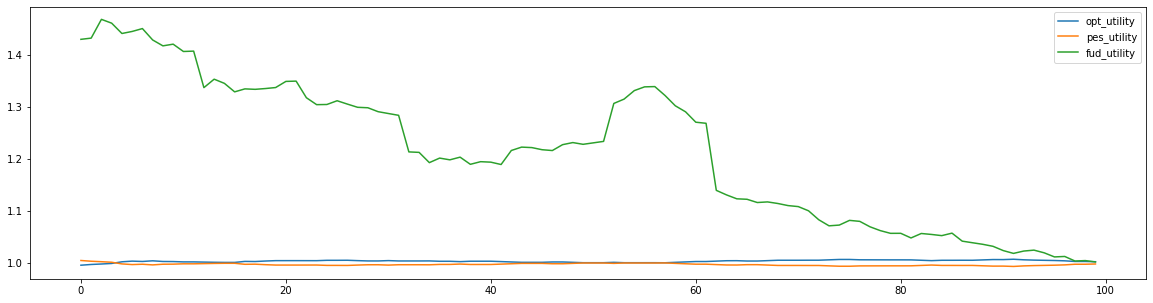

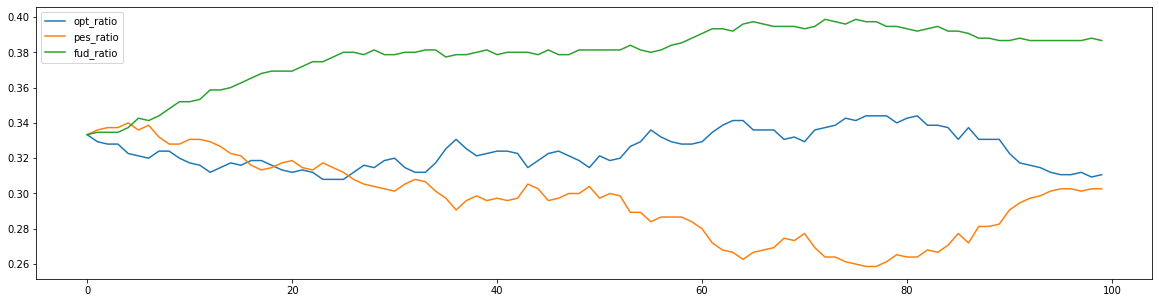

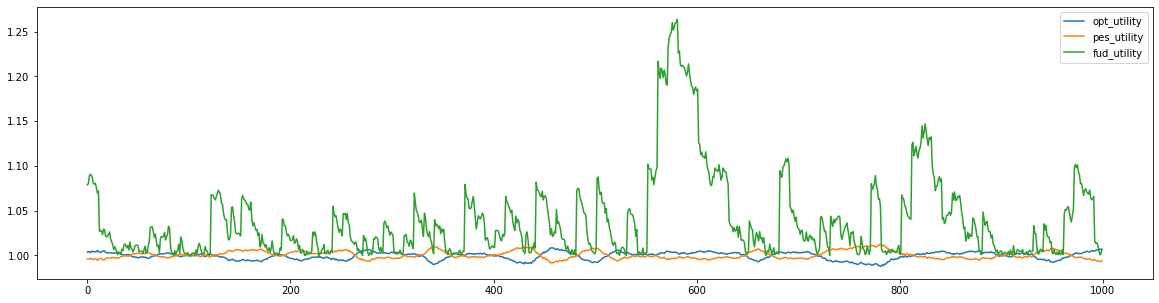

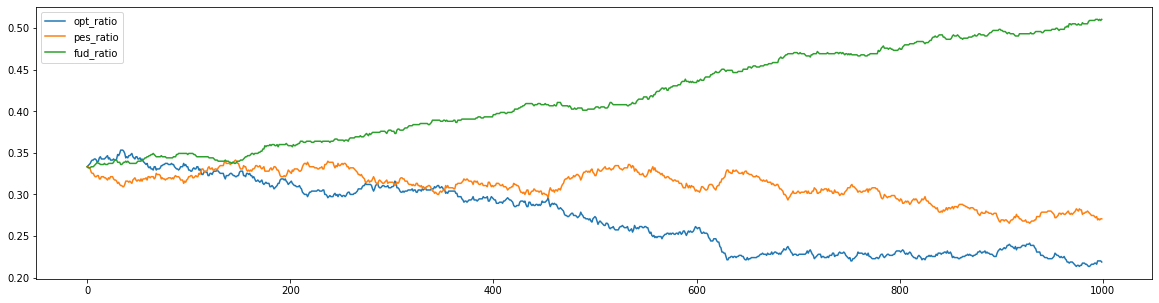

In [38]:
for rl_state in rl_states:
    for i, item in enumerate(['opt_utility', 'pes_utility', 'fud_utility']):
        l = [state['observations'][i] for state in rl_state[agent_id]['states']]
        plt.plot(l, label = item)
    plt.legend()
    plt.show()

    for i, item in enumerate(['opt_ratio', 'pes_ratio', 'fud_ratio']):
        l = [state['observations'][i+3] for state in rl_state[agent_id]['states']]
        plt.plot(l, label = item)
    plt.legend()
    plt.show()


## Validate

In [39]:
num_validate_dirs = len(os.listdir(record_path / 'validate'))
validate_dirs = [record_path / 'validate' / f'sim_{i}' for i in range(num_validate_dirs)]

val_markets, val_agents, val_rl_states, val_lengths, val_timesteps = [], [], [], [], []
for _dir in validate_dirs:
    security_path = _dir / "TSMC.json"
    agent_path = _dir / "agent.json"
    rl_path = _dir / 'rl_agent.json'
    config_path = _dir / 'config.json'
    market = json.loads(security_path.read_text())
    val_markets.append(market)
    val_agents.append(json.loads(agent_path.read_text()))
    val_rl_states.append(json.loads(rl_path.read_text()))
    val_lengths.append(len(market['price']))
    val_timesteps.append([i for i in range(len(market['price']))])
    
print(f"Simulation times: {len(validate_dirs)}")

Simulation times: 2


In [40]:
markets = val_markets
agents = val_agents
rl_states = val_rl_states
lengths = val_lengths
timesteps = val_timesteps
print(f"Average validate length: {sum(lengths) / len(lengths)}")

Average validate length: 1250.0


### Price & Value

In [ ]:
for market in markets:
    plt.plot(market['price'])

In [ ]:
# Average price & value
avg_prices, avg_values = [], []
for market in markets:
    avg_prices.append(sum(market['price']) / len(market['price']))
    avg_values.append(sum(market['value']) / len(market['value']))

plt.plot(avg_prices, label = 'Price')
plt.plot(avg_values, label = 'Value')
plt.legend()

In [ ]:
for market in markets:
    plt.plot(market['price'][250:], label = 'price')
    plt.plot(market['value'][250:], label = 'value')
    plt.legend()
    plt.show()


### Bid & Ask

In [ ]:
avg_bids, avg_asks = [], []
for market in markets:
    avg_bids.append(sum(market['bid']) / len(market['bid']))
    avg_asks.append(sum(market['ask']) / len(market['ask']))

plt.plot(avg_bids, label = 'Bid')
plt.plot(avg_asks, label = 'Ask')
plt.legend()
plt.show()
print(f"Average step per bid quantity per agent: {1 / (sum([sum(market['bid']) / len(market['bid']) for market in markets]) / len(markets) / num_agent)}")
print(f"Average step per ask quantity per agent: {1 / (sum([sum(market['ask']) / len(market['ask']) for market in markets]) / len(markets) / num_agent)}")

In [ ]:
for market in markets:
    plt.plot(market['bid'], label = 'Bid quantity')
    plt.plot(market['ask'], label = 'Ask quantity')
    plt.legend()
    plt.show()

### Agent returns

#### Distribution of total returns 

In [ ]:
all_agent_returns = []
for rl_state in rl_states:
    for agent_state in rl_state.values():
        returns = (agent_state['states'][-1]['agent_state']['wealth'] - agent_state['states'][0]['agent_state']['wealth']) / agent_state['states'][0]['agent_state']['wealth']
        all_agent_returns.append(round(returns * 100))

In [ ]:
num_pos_returns = len([ret for ret in all_agent_returns if ret > 0])
num_neg_returns = len([ret for ret in all_agent_returns if ret < 0])
agent_returns_counter = Counter(all_agent_returns)
returns_x = sorted(agent_returns_counter.keys())
returns_y = [agent_returns_counter[x] for x in returns_x]
plt.scatter(returns_x, returns_y)
print(f"Rate of positive returns: {num_pos_returns / (num_pos_returns + num_neg_returns)}")
print(f"Rate of negtive returns: {num_neg_returns / (num_pos_returns + num_neg_returns)}")

#### Distribution of returns by agent

In [ ]:
agent_ids = rl_states[0].keys()
agent_returns = {agent_id: [] for agent_id in agent_ids}

for rl_state in rl_states:
    for agent_id, agent_state in rl_state.items():
        returns = (agent_state['states'][-1]['agent_state']['wealth'] - agent_state['states'][0]['agent_state']['wealth']) / agent_state['states'][0]['agent_state']['wealth']
        agent_returns[agent_id].append(round(returns * 100, 2))

In [ ]:
avg_agent_returns = [round(sum(agent_return) / len(agent_return)) for agent_return in agent_returns.values()]
agent_returns_counter = Counter(avg_agent_returns)
returns_x = sorted(agent_returns_counter.keys())
returns_y = [agent_returns_counter[x] for x in returns_x]
plt.scatter(returns_x, returns_y)

In [ ]:
plt.figure(figsize=(40, 10))
returns_progress = [returns[-1] - returns[0] for returns in agent_returns.values()]
plt.scatter(list(range(len(returns_progress))), returns_progress)
num_pos_progress = len([progress for progress in returns_progress if progress > 0])
num_neg_progress = len([progress for progress in returns_progress if progress < 0])
print(f"Positive progress: {num_pos_progress / len(returns_progress)}")
print(f"Negative progress: {num_neg_progress / len(returns_progress)}")


### Action rate

In [ ]:
group_names = list(agents[0].keys())
group_names

In [ ]:
action_ref = {0: "BID", 1: "ASK", 2: "HOLD"}
tick_ref = {i: tick for i, tick in zip(list(range(0, 9)), list(range(-4, 5)))}
agent_actions = {"BID": 0, "ASK": 0, "HOLD": 0}
agent_ticks = defaultdict(int)
agent_volume = defaultdict(int)
group_names = list(agents[0].keys())
group_agent_actions = {group_name: {"BID": 0, "ASK": 0, "HOLD": 0} for group_name in group_names}
for state in rl_states:
    for agent_id, agent in state.items():
        for group_name in group_names:
            if agent_id.startswith(group_name):
                break
        for action in agent['actions']:
            trade_action = action_ref[action[0]]
            tick = 1
            volume = 1
            group_agent_actions[group_name][trade_action] += 1
            agent_actions[trade_action] += 1
            agent_ticks[tick] += 1
            agent_volume[volume] += 1
total_actions = sum(agent_actions.values())
print(f"Total action rate\nBid: {agent_actions['BID'] / total_actions} Ask: {agent_actions['ASK'] / total_actions} Hold: {agent_actions['HOLD'] / total_actions}")
print(f"Group action rate")
for group_name in group_names:
    group_total_actions = total_actions / len(group_names)
    print(f"{group_name}, Bid: {group_agent_actions[group_name]['BID'] / group_total_actions} Ask: {group_agent_actions[group_name]['ASK'] / group_total_actions} Hold: {group_agent_actions[group_name]['HOLD'] / group_total_actions}")





In [ ]:
ticks = sorted(list(agent_ticks.keys()))
plt.scatter(ticks, [agent_ticks[tick] for tick in ticks])

In [ ]:
volumes = sorted(list(agent_volume.keys()))
plt.scatter(volumes, [agent_volume[volume] for volume in volumes])

### Sample agent

#### Value agent

In [ ]:
# sample agent to analyse
value_group_name = "ppo_va_250"
value_agent_number = 250
value_agent_id = f"{value_group_name}_{random.randint(0, 249)}"
rl_state = rl_states[-1]
market = markets[-1]
tick_size = 0.1
agent_id = random.sample(agent_ids, 1)[0]


In [ ]:
# Holdings
for i, rl_state in enumerate(rl_states):
    agent_state = rl_state[agent_id]['states']
    cash = [state['cash'] for state in agent_state]
    holding = [state['TSMC'] for state in agent_state]
    wealth = [state['wealth'] for state in agent_state]
    plt.plot(wealth, label = f"sim_{i}")
    plt.legend()


In [ ]:
# Holdings
agent_state = rl_states[-1][agent_id]['states']
cash = [state['cash'] for state in agent_state]
holding = [state['TSMC'] for state in agent_state]
wealth = [state['wealth'] for state in agent_state]
plt.plot(cash, label = "Cash")
plt.plot(wealth, label = "Wealth")
plt.legend()
plt.show()
plt.plot(holding, label = "TSMC")
plt.legend()

In [ ]:
# sample agent to analyse
value_agent_number = 1
value_group_name = f"ppo_tr_{value_agent_number}"
value_agent_id = f"{value_group_name}_{random.randint(0, value_agent_number - 1)}"
rl_state = rl_states[-1]
market = markets[-1]
tick_size = 0.1
agent_id = random.sample(agent_ids, 1)[0]

action_ref = {0: "BID", 1: "ASK", 2: "HOLD"}
tick_ref = {i: tick for i, tick in zip(list(range(0, 9)), list(range(-4, 5)))}
print(value_agent_id)
for state, market in zip(rl_states, markets):
    orders = []
    counter = {"BID": 0, "ASK": 0, "HOLD": 0}
    for i, action in enumerate(state[value_agent_id]['actions']):
        bid_or_ask = action_ref[action[0]]
        ticks = 1
        price = market['price'][249+i] + tick_size * ticks
        volume = 1
        order = {'time': i, "bid_or_ask": bid_or_ask, "price": price, "volume": volume}
        counter[bid_or_ask] += 1
        orders.append(order)

    total_actions = sum(counter.values())
    print(counter)
    print(f"Bid: {counter['BID'] / total_actions}\nAsk: {counter['ASK'] / total_actions}\nHold: {counter['HOLD'] / total_actions}")
    bid_x, bid_y = [], []
    ask_x, ask_y = [], []
    bid_sizes, ask_sizes = [], []
    bid_colors, ask_colors = [], []
    base_size = 10
    for i, order in enumerate(orders):
        if order['bid_or_ask'] == 'BID':
    #         if order['time'] > 5000 and order['time'] < 5100:
            bid_x.append(order['time'])
            bid_y.append(order['price'])
            bid_colors.append('r')
            bid_sizes.append(base_size * order['volume'])
        if order['bid_or_ask'] == 'ASK':
    #         if order['time'] > 5000 and order['time'] < 5100:
            ask_x.append(order['time'])
            ask_y.append(order['price'])
            ask_colors.append('g')  
            ask_sizes.append(base_size * order['volume'])
    plot_price = market['price'][250:]
    plot_value = market['value'][250:]
    x = np.arange(len(plot_price))
    plt.figure(figsize=(80, 20))
    plt.plot(x, plot_price, label = "price")
    plt.plot(x, plot_value, label = "value")
    plt.legend()
    plt.scatter(bid_x, bid_y, s = bid_sizes, c = bid_colors, marker = 6)
    plt.scatter(ask_x, ask_y, s = ask_sizes, c = ask_colors, marker = 7)
    plt.show()

In [ ]:
for rl_state in rl_states:
    gaps = [state['observations'][0] for state in rl_state[agent_id]['states']]
    prices = [state['observations'][1] for state in rl_state[agent_id]['states']]
    wealths = [state['observations'][2] for state in rl_state[agent_id]['states']]
    actions = [action[0] for action in rl_state[agent_id]['actions']]

    expections = {'Good': 0, 'Bad': 0, 'Hold': 0}
    for gap, action in zip(gaps, actions):
        if gap >= 0:
            if action == 1:
                expections['Good'] += 1
            elif action == 0:
                expections['Bad'] += 1
            else:
                expections['Hold'] += 1
        if gap < 0:
            if action == 0:
                expections['Good'] += 1
            elif action == 1:
                expections['Bad'] += 1
            else:
                expections['Hold'] += 1
    print(f"Good: {expections['Good'] / len(gaps)}, Bad: {expections['Bad'] / len(gaps)}, Hold: {expections['Hold'] / len(gaps)}")

#### Scaling agent

In [41]:
group_name = f"ppo_sc_{agent_number}"
agent_id = f"{group_name}_{random.randint(0, agent_number-1)}"
rl_state = rl_states[0]
market = markets[0]
tick_size = 0.1


In [44]:
for i, rl_state in enumerate(rl_states):
    wealth_gain = 100 * (rl_state[agent_id]['states'][-1]['agent_state']['wealth'] - rl_state[agent_id]['states'][0]['agent_state']['wealth']) / rl_state[agent_id]['states'][0]['agent_state']['wealth']
    print(f"In sim_{i}, wealth gain: {round(wealth_gain, 2)}%")

In sim_0, wealth gain: 42.28%
In sim_1, wealth gain: -3.94%


ppo_sc_1_0
{'opt': 637, 'pes': 356, 'fud': 7}
opt: 0.637
pes: 0.356
fud: 0.007


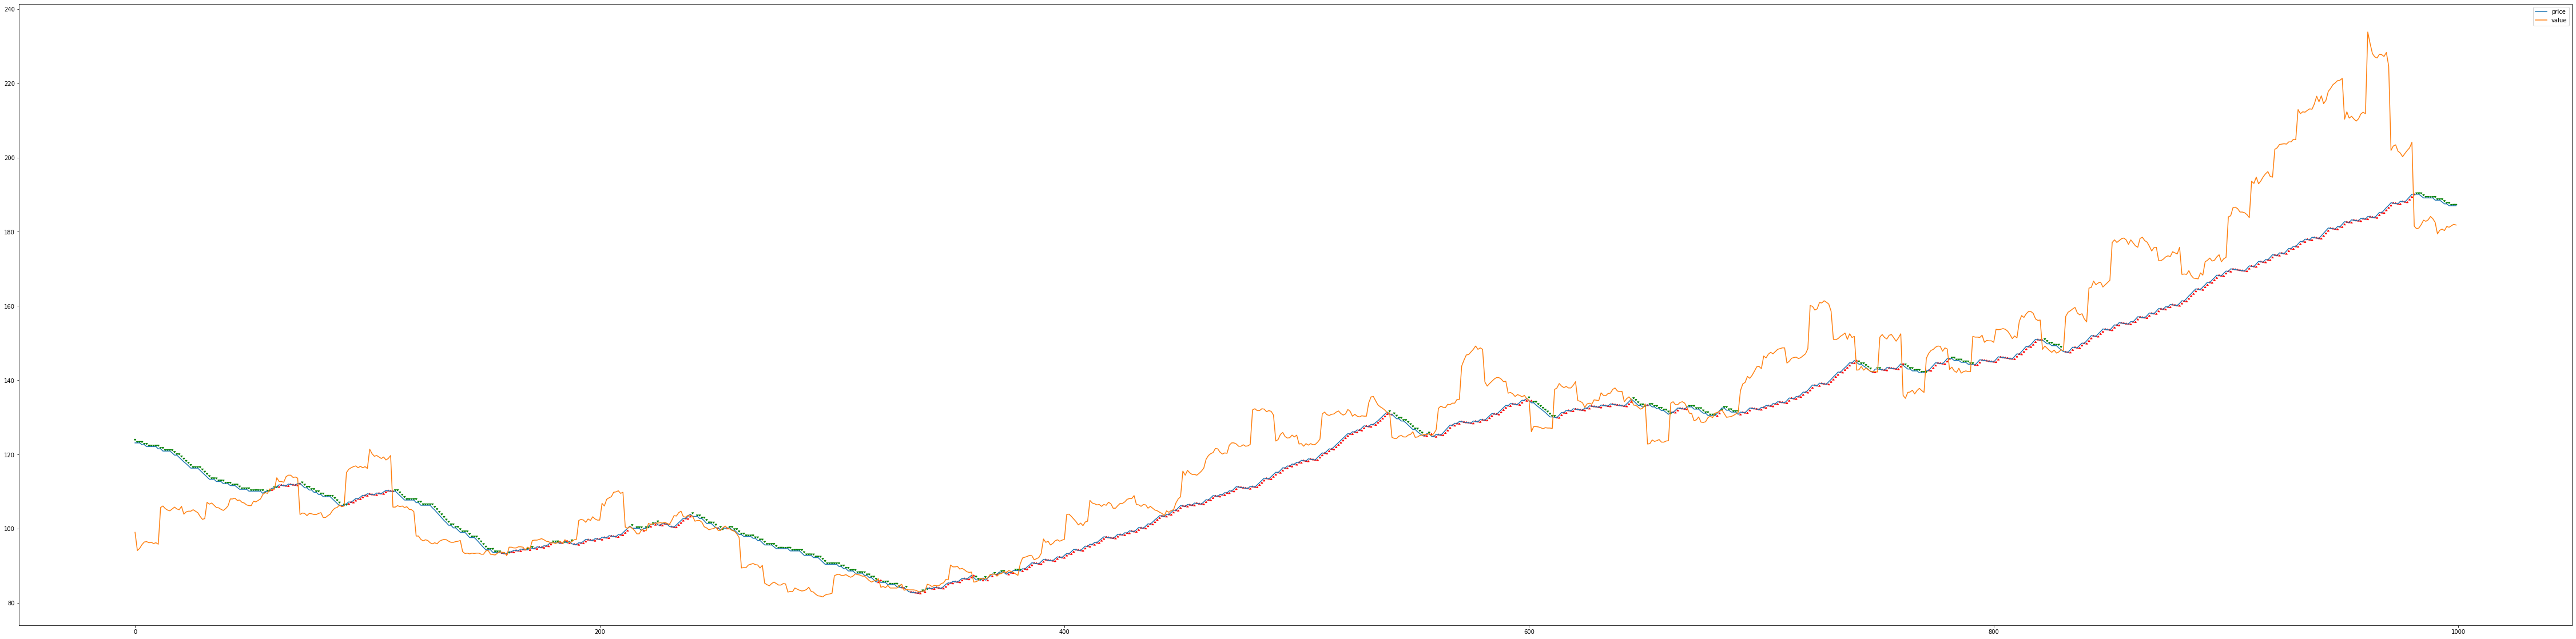

{'opt': 530, 'pes': 458, 'fud': 12}
opt: 0.53
pes: 0.458
fud: 0.012


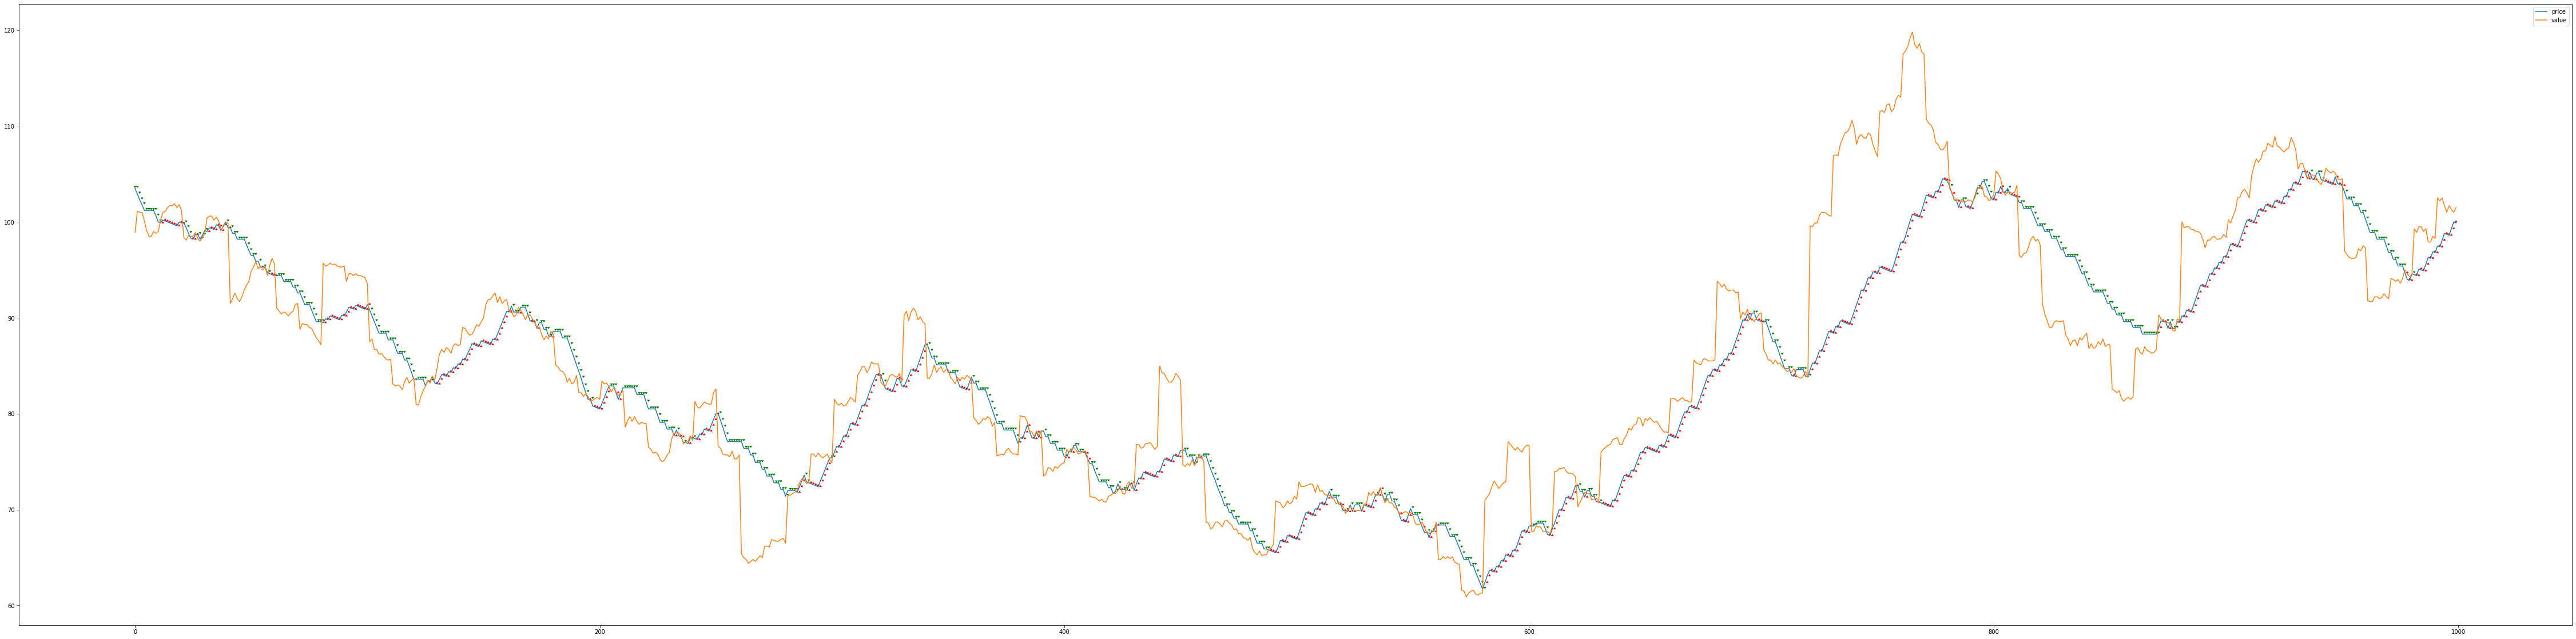

In [45]:
action_ref = {0: "opt", 1: "pes", 2: "fud"}
tick_ref = {i: tick for i, tick in zip(list(range(0, 9)), list(range(-4, 5)))}
print(agent_id)
for state, market in zip(rl_states, markets):
    orders = []
    counter = {"opt": 0, "pes": 0, "fud": 0}
    for i, action in enumerate(state[agent_id]['actions']):
        group = action_ref[action[0]]
        ticks = 1
        price = market['price'][249+i] + tick_size * ticks
        volume = 1
        order = {'time': i, "group": group, "price": price, "volume": volume}
        counter[group] += 1
        orders.append(order)

    total_actions = sum(counter.values())
    print(counter)
    print(f"opt: {counter['opt'] / total_actions}\npes: {counter['pes'] / total_actions}\nfud: {counter['fud'] / total_actions}")
    bid_x, bid_y = [], []
    ask_x, ask_y = [], []
    bid_sizes, ask_sizes = [], []
    bid_colors, ask_colors = [], []
    base_size = 10
    for i, order in enumerate(orders):
        if order['group'] == 'opt':
    #         if order['time'] > 5000 and order['time'] < 5100:
            bid_x.append(order['time'])
            bid_y.append(order['price'])
            bid_colors.append('r')
            bid_sizes.append(base_size * order['volume'])
        if order['group'] == 'pes':
    #         if order['time'] > 5000 and order['time'] < 5100:
            ask_x.append(order['time'])
            ask_y.append(order['price'])
            ask_colors.append('g')  
            ask_sizes.append(base_size * order['volume'])
    plot_price = market['price'][250:]
    plot_value = market['value'][250:]
    x = np.arange(len(plot_price))
    plt.figure(figsize=(80, 20))
    plt.plot(x, plot_price, label = "price")
    plt.plot(x, plot_value, label = "value")
    plt.legend()
    plt.scatter(bid_x, bid_y, s = bid_sizes, c = bid_colors, marker = 6)
    plt.scatter(ask_x, ask_y, s = ask_sizes, c = ask_colors, marker = 7)
    plt.show()
    

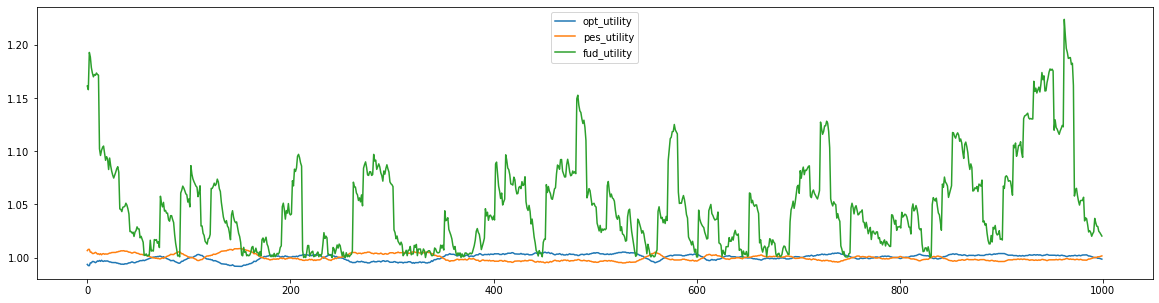

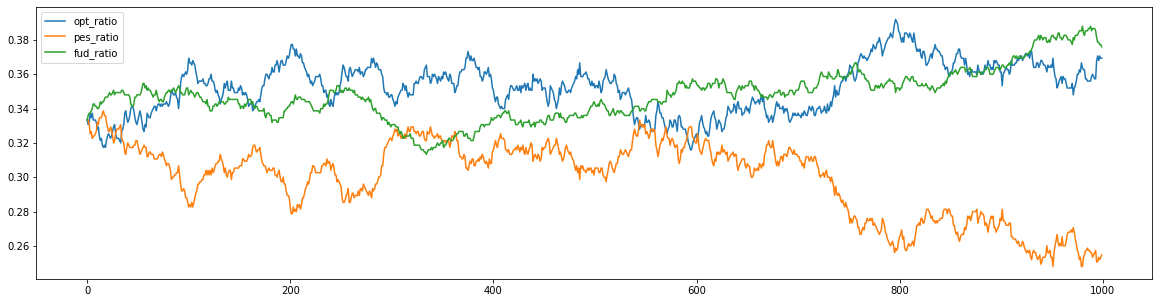

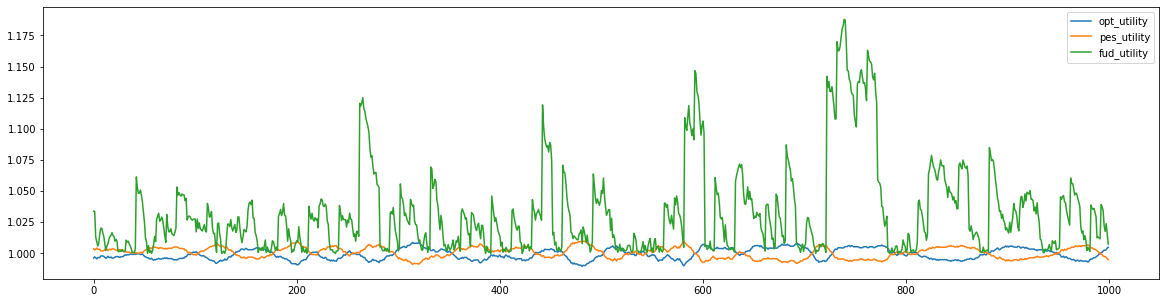

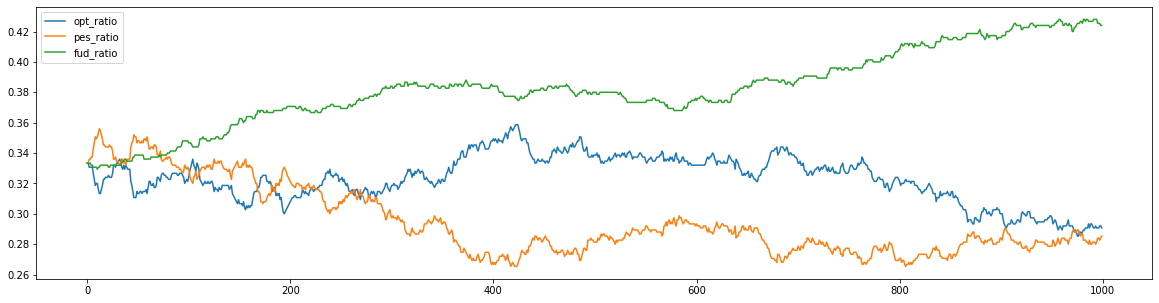

In [46]:
for rl_state in rl_states:
    for i, item in enumerate(['opt_utility', 'pes_utility', 'fud_utility']):
        l = [state['observations'][i] for state in rl_state[agent_id]['states']]
        plt.plot(l, label = item)
    plt.legend()
    plt.show()

    for i, item in enumerate(['opt_ratio', 'pes_ratio', 'fud_ratio']):
        l = [state['observations'][i+3] for state in rl_state[agent_id]['states']]
        plt.plot(l, label = item)
    plt.legend()
    plt.show()


## Predict

In [92]:
num_predict_dirs = len(os.listdir(record_path / 'predict'))
predict_dirs = [record_path / 'predict' / f'sim_{i}' for i in range(num_predict_dirs)]

pre_markets, pre_agents, pre_rl_states, pre_lengths, pre_timesteps = [], [], [], [], []
for _dir in predict_dirs:
    security_path = _dir / "TSMC.json"
    agent_path = _dir / "agent.json"
    rl_path = _dir / 'rl_agent.json'
    config_path = _dir / 'config.json'
    market = json.loads(security_path.read_text())
    pre_markets.append(market)
    pre_agents.append(json.loads(agent_path.read_text()))
    pre_rl_states.append(json.loads(rl_path.read_text()))
    pre_lengths.append(len(market['price']))
    pre_timesteps.append([i for i in range(len(market['price']))])
    
print(f"Simulation times: {len(predict_dirs)}")

Simulation times: 5


In [93]:
markets = pre_markets
agents = pre_agents
rl_states = pre_rl_states
lengths = pre_lengths
timesteps = pre_timesteps
print(f"Average validate length: {sum(lengths) / len(lengths)}")

Average validate length: 1250.0


### Price & Value

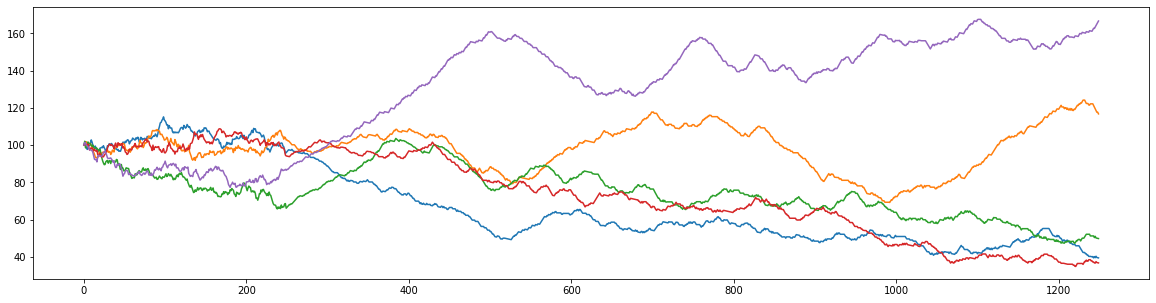

In [94]:
for market in markets:
    plt.plot(market['price'])

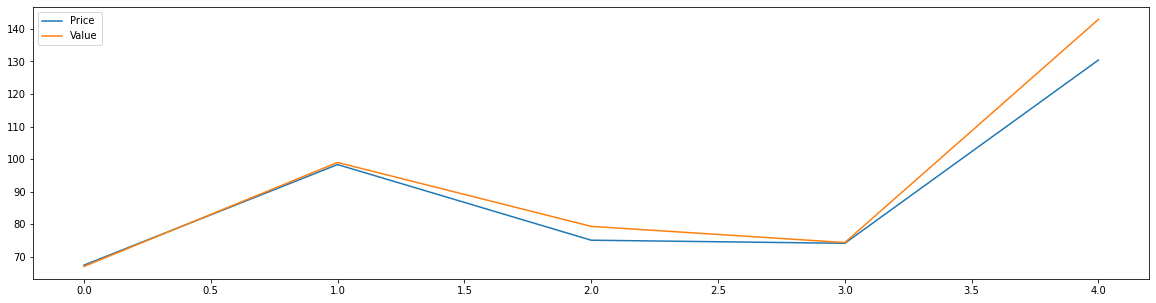

In [95]:
# Average price & value
avg_prices, avg_values = [], []
for market in markets:
    avg_prices.append(sum(market['price']) / len(market['price']))
    avg_values.append(sum(market['value']) / len(market['value']))

plt.plot(avg_prices, label = 'Price')
plt.plot(avg_values, label = 'Value')
plt.legend()

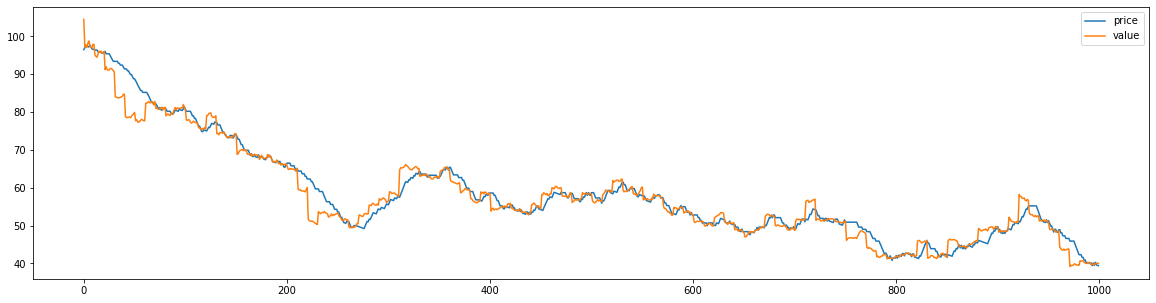

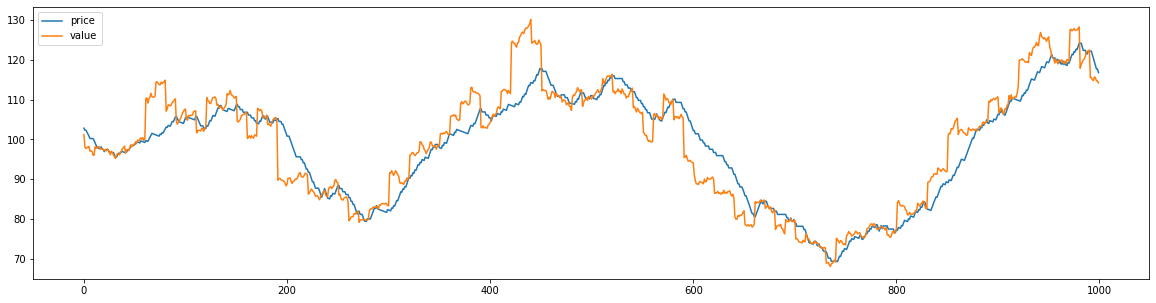

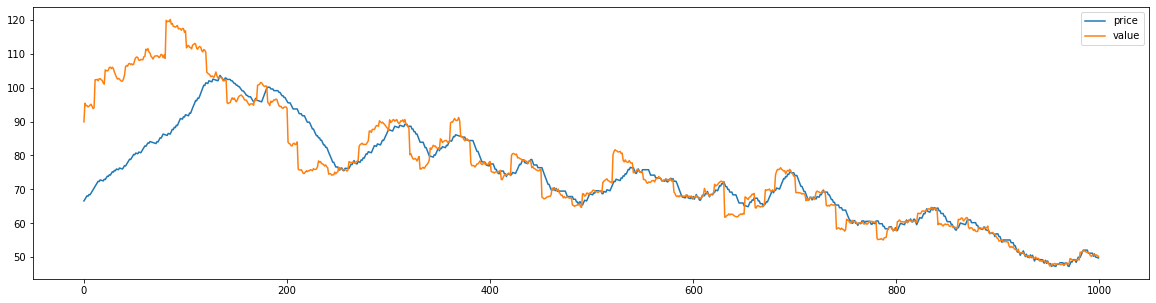

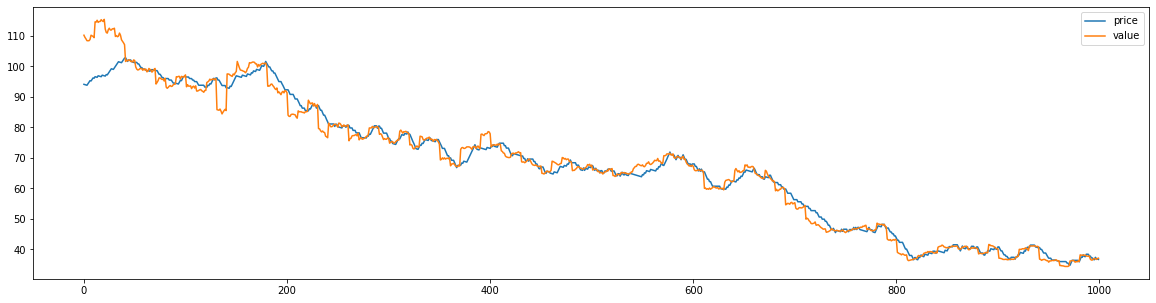

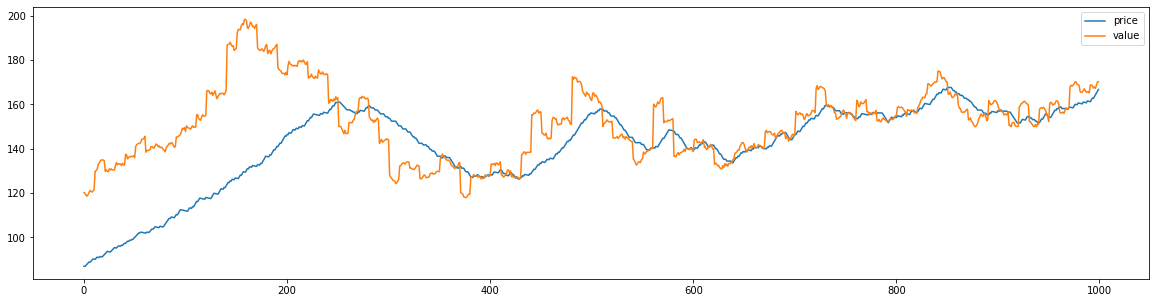

In [96]:
for market in markets:
    plt.plot(market['price'][250:], label = 'price')
    plt.plot(market['value'][250:], label = 'value')
    plt.legend()
    plt.show()


### Bid & Ask

In [ ]:
avg_bids, avg_asks = [], []
for market in markets:
    avg_bids.append(sum(market['bid']) / len(market['bid']))
    avg_asks.append(sum(market['ask']) / len(market['ask']))

plt.plot(avg_bids, label = 'Bid')
plt.plot(avg_asks, label = 'Ask')
plt.legend()
plt.show()
print(f"Average step per bid quantity per agent: {1 / (sum([sum(market['bid']) / len(market['bid']) for market in markets]) / len(markets) / num_agent)}")
print(f"Average step per ask quantity per agent: {1 / (sum([sum(market['ask']) / len(market['ask']) for market in markets]) / len(markets) / num_agent)}")

In [ ]:
for market in markets:
    plt.plot(market['bid'], label = 'Bid quantity')
    plt.plot(market['ask'], label = 'Ask quantity')
    plt.legend()
    plt.show()

### Agent returns

#### Distribution of total returns 

In [97]:
all_agent_returns = []
for rl_state in rl_states:
    for agent_state in rl_state.values():
        returns = (agent_state['states'][-1]['agent_state']['wealth'] - agent_state['states'][0]['agent_state']['wealth']) / agent_state['states'][0]['agent_state']['wealth']
        all_agent_returns.append(round(returns * 100))

Rate of positive returns: 0.6229903536977492
Rate of negtive returns: 0.3770096463022508


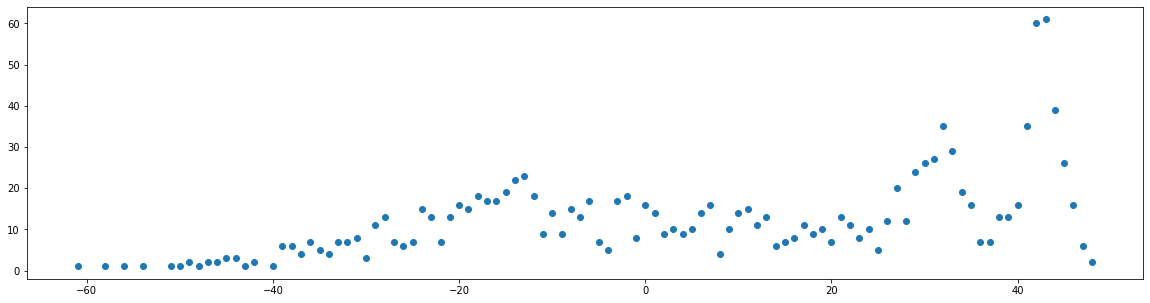

In [98]:
num_pos_returns = len([ret for ret in all_agent_returns if ret > 0])
num_neg_returns = len([ret for ret in all_agent_returns if ret < 0])
agent_returns_counter = Counter(all_agent_returns)
returns_x = sorted(agent_returns_counter.keys())
returns_y = [agent_returns_counter[x] for x in returns_x]
plt.scatter(returns_x, returns_y)
print(f"Rate of positive returns: {num_pos_returns / (num_pos_returns + num_neg_returns)}")
print(f"Rate of negtive returns: {num_neg_returns / (num_pos_returns + num_neg_returns)}")

#### Distribution of returns by agent

In [99]:
agent_ids = rl_states[0].keys()
agent_returns = {agent_id: [] for agent_id in agent_ids}

for rl_state in rl_states:
    for agent_id, agent_state in rl_state.items():
        returns = (agent_state['states'][-1]['agent_state']['wealth'] - agent_state['states'][0]['agent_state']['wealth']) / agent_state['states'][0]['agent_state']['wealth']
        agent_returns[agent_id].append(round(returns * 100, 2))

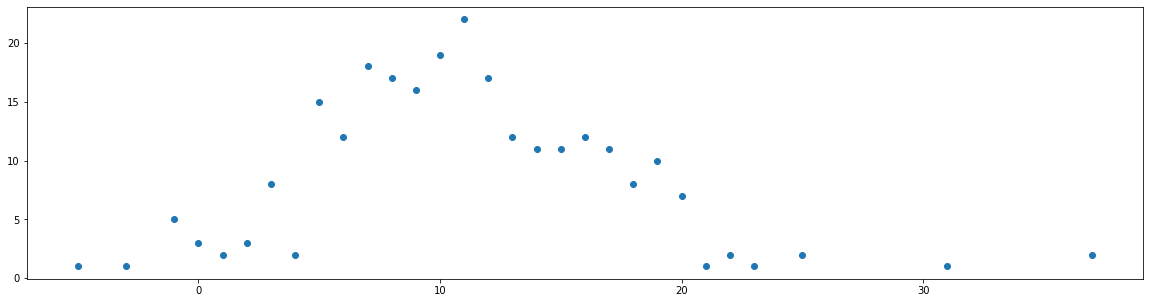

In [100]:
avg_agent_returns = [round(sum(agent_return) / len(agent_return)) for agent_return in agent_returns.values()]
agent_returns_counter = Counter(avg_agent_returns)
returns_x = sorted(agent_returns_counter.keys())
returns_y = [agent_returns_counter[x] for x in returns_x]
plt.scatter(returns_x, returns_y)

### Action rate

In [102]:
group_names = list(agents[0].keys())
group_names

['sc_opt_250',
 'sc_pes_250',
 'sc_fud_250',
 'ppo_tr_1',
 'ppo_va_1',
 'ppo_sc_250']

In [103]:
action_ref = {0: "BID", 1: "ASK", 2: "HOLD"}
tick_ref = {i: tick for i, tick in zip(list(range(0, 9)), list(range(-4, 5)))}
agent_actions = {"BID": 0, "ASK": 0, "HOLD": 0}
agent_ticks = defaultdict(int)
agent_volume = defaultdict(int)
group_names = list(agents[0].keys())
group_agent_actions = {group_name: {"BID": 0, "ASK": 0, "HOLD": 0} for group_name in group_names}
for state in rl_states:
    for agent_id, agent in state.items():
        for group_name in group_names:
            if agent_id.startswith(group_name):
                break
        for action in agent['actions']:
            trade_action = action_ref[action[0]]
            tick = 1
            volume = 1
            group_agent_actions[group_name][trade_action] += 1
            agent_actions[trade_action] += 1
            agent_ticks[tick] += 1
            agent_volume[volume] += 1
total_actions = sum(agent_actions.values())
print(f"Total action rate\nBid: {agent_actions['BID'] / total_actions} Ask: {agent_actions['ASK'] / total_actions} Hold: {agent_actions['HOLD'] / total_actions}")
print(f"Group action rate")
for group_name in group_names:
    group_total_actions = total_actions / len(group_names)
    print(f"{group_name}, Bid: {group_agent_actions[group_name]['BID'] / group_total_actions} Ask: {group_agent_actions[group_name]['ASK'] / group_total_actions} Hold: {group_agent_actions[group_name]['HOLD'] / group_total_actions}")





Total action rate
Bid: 0.520436507936508 Ask: 0.45694444444444443 Hold: 0.02261904761904762
Group action rate
sc_opt_250, Bid: 0.0 Ask: 0.0 Hold: 0.0
sc_pes_250, Bid: 0.0 Ask: 0.0 Hold: 0.0
sc_fud_250, Bid: 0.0 Ask: 0.0 Hold: 0.0
ppo_tr_1, Bid: 0.0 Ask: 0.023809523809523808 Hold: 0.0
ppo_va_1, Bid: 0.0 Ask: 0.023809523809523808 Hold: 0.0
ppo_sc_250, Bid: 3.1226190476190476 Ask: 2.6940476190476192 Hold: 0.1357142857142857


### Sample agent

#### Value agent

In [ ]:
# sample agent to analyse
value_group_name = "ppo_va_250"
value_agent_number = 250
value_agent_id = f"{value_group_name}_{random.randint(0, 249)}"
rl_state = rl_states[-1]
market = markets[-1]
tick_size = 0.1
agent_id = random.sample(agent_ids, 1)[0]


In [ ]:
# Holdings
for i, rl_state in enumerate(rl_states):
    agent_state = rl_state[agent_id]['states']
    cash = [state['cash'] for state in agent_state]
    holding = [state['TSMC'] for state in agent_state]
    wealth = [state['wealth'] for state in agent_state]
    plt.plot(wealth, label = f"sim_{i}")
    plt.legend()


In [ ]:
# Holdings
agent_state = rl_states[-1][agent_id]['states']
cash = [state['cash'] for state in agent_state]
holding = [state['TSMC'] for state in agent_state]
wealth = [state['wealth'] for state in agent_state]
plt.plot(cash, label = "Cash")
plt.plot(wealth, label = "Wealth")
plt.legend()
plt.show()
plt.plot(holding, label = "TSMC")
plt.legend()

In [ ]:
# sample agent to analyse
value_agent_number = 1
value_group_name = f"ppo_tr_{value_agent_number}"
value_agent_id = f"{value_group_name}_{random.randint(0, value_agent_number - 1)}"
rl_state = rl_states[-1]
market = markets[-1]
tick_size = 0.1
agent_id = random.sample(agent_ids, 1)[0]

action_ref = {0: "BID", 1: "ASK", 2: "HOLD"}
tick_ref = {i: tick for i, tick in zip(list(range(0, 9)), list(range(-4, 5)))}
print(value_agent_id)
for state, market in zip(rl_states, markets):
    orders = []
    counter = {"BID": 0, "ASK": 0, "HOLD": 0}
    for i, action in enumerate(state[value_agent_id]['actions']):
        bid_or_ask = action_ref[action[0]]
        ticks = 1
        price = market['price'][249+i] + tick_size * ticks
        volume = 1
        order = {'time': i, "bid_or_ask": bid_or_ask, "price": price, "volume": volume}
        counter[bid_or_ask] += 1
        orders.append(order)

    total_actions = sum(counter.values())
    print(counter)
    print(f"Bid: {counter['BID'] / total_actions}\nAsk: {counter['ASK'] / total_actions}\nHold: {counter['HOLD'] / total_actions}")
    bid_x, bid_y = [], []
    ask_x, ask_y = [], []
    bid_sizes, ask_sizes = [], []
    bid_colors, ask_colors = [], []
    base_size = 10
    for i, order in enumerate(orders):
        if order['bid_or_ask'] == 'BID':
    #         if order['time'] > 5000 and order['time'] < 5100:
            bid_x.append(order['time'])
            bid_y.append(order['price'])
            bid_colors.append('r')
            bid_sizes.append(base_size * order['volume'])
        if order['bid_or_ask'] == 'ASK':
    #         if order['time'] > 5000 and order['time'] < 5100:
            ask_x.append(order['time'])
            ask_y.append(order['price'])
            ask_colors.append('g')  
            ask_sizes.append(base_size * order['volume'])
    plot_price = market['price'][250:]
    plot_value = market['value'][250:]
    x = np.arange(len(plot_price))
    plt.figure(figsize=(80, 20))
    plt.plot(x, plot_price, label = "price")
    plt.plot(x, plot_value, label = "value")
    plt.legend()
    plt.scatter(bid_x, bid_y, s = bid_sizes, c = bid_colors, marker = 6)
    plt.scatter(ask_x, ask_y, s = ask_sizes, c = ask_colors, marker = 7)
    plt.show()

In [ ]:
for rl_state in rl_states:
    gaps = [state['observations'][0] for state in rl_state[agent_id]['states']]
    prices = [state['observations'][1] for state in rl_state[agent_id]['states']]
    wealths = [state['observations'][2] for state in rl_state[agent_id]['states']]
    actions = [action[0] for action in rl_state[agent_id]['actions']]

    expections = {'Good': 0, 'Bad': 0, 'Hold': 0}
    for gap, action in zip(gaps, actions):
        if gap >= 0:
            if action == 1:
                expections['Good'] += 1
            elif action == 0:
                expections['Bad'] += 1
            else:
                expections['Hold'] += 1
        if gap < 0:
            if action == 0:
                expections['Good'] += 1
            elif action == 1:
                expections['Bad'] += 1
            else:
                expections['Hold'] += 1
    print(f"Good: {expections['Good'] / len(gaps)}, Bad: {expections['Bad'] / len(gaps)}, Hold: {expections['Hold'] / len(gaps)}")

#### Scaling agent

In [106]:
group_name = f"ppo_sc_{agent_number}"
agent_id = f"{group_name}_{random.randint(0, agent_number-1)}"
rl_state = rl_states[0]
market = markets[0]
tick_size = 0.1


In [107]:
for i, rl_state in enumerate(rl_states):
    wealth_gain = 100 * (rl_state[agent_id]['states'][-1]['agent_state']['wealth'] - rl_state[agent_id]['states'][0]['agent_state']['wealth']) / rl_state[agent_id]['states'][0]['agent_state']['wealth']
    print(f"In sim_{i}, wealth gain: {round(wealth_gain, 2)}%")

In sim_0, wealth gain: -29.15%
In sim_1, wealth gain: 35.45%
In sim_2, wealth gain: 3.82%
In sim_3, wealth gain: -23.98%
In sim_4, wealth gain: 43.41%


ppo_sc_250_14
{'opt': 443, 'pes': 524, 'fud': 33}
opt: 0.443
pes: 0.524
fud: 0.033


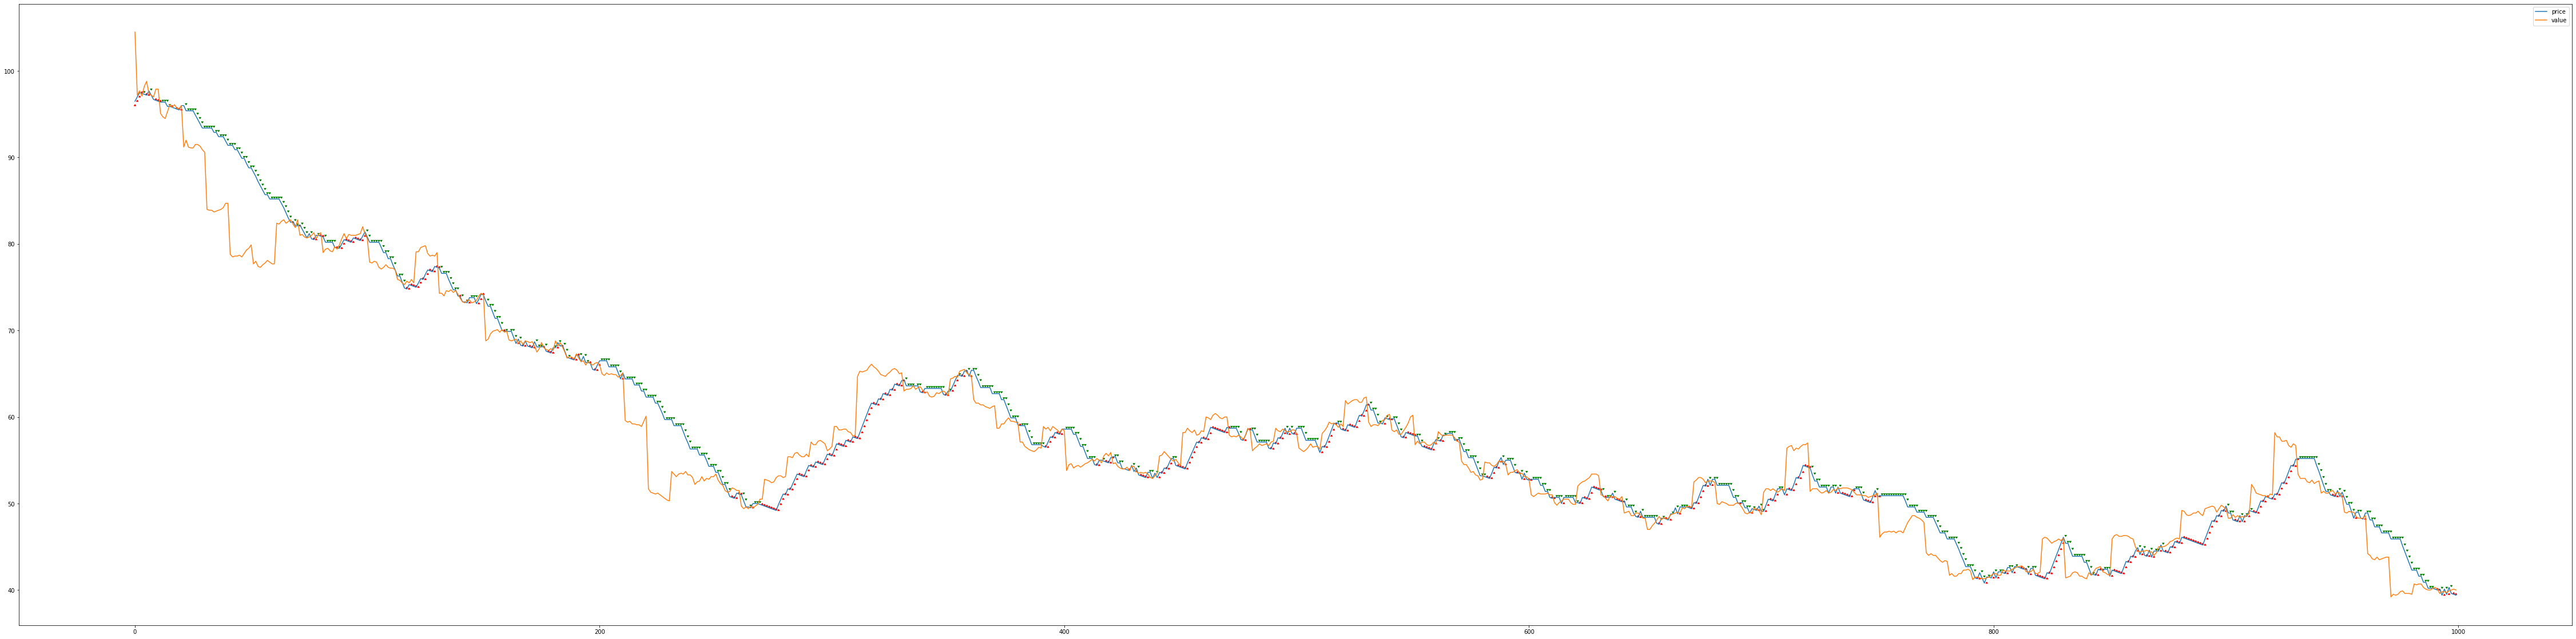

{'opt': 566, 'pes': 410, 'fud': 24}
opt: 0.566
pes: 0.41
fud: 0.024


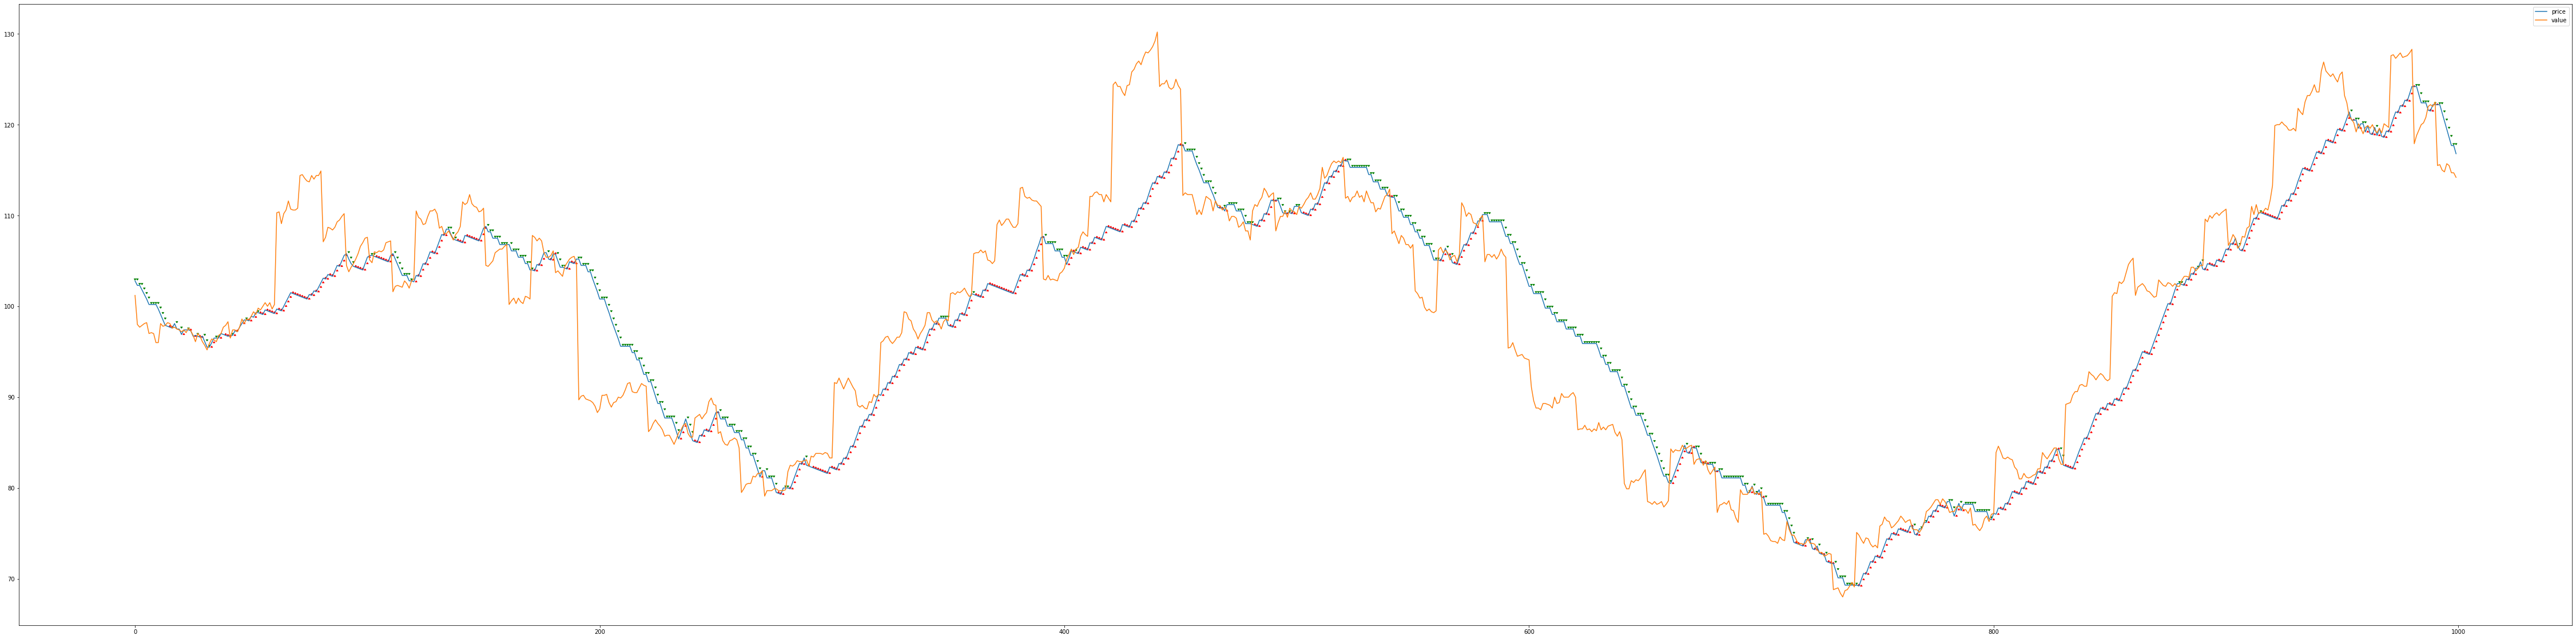

{'opt': 507, 'pes': 474, 'fud': 19}
opt: 0.507
pes: 0.474
fud: 0.019


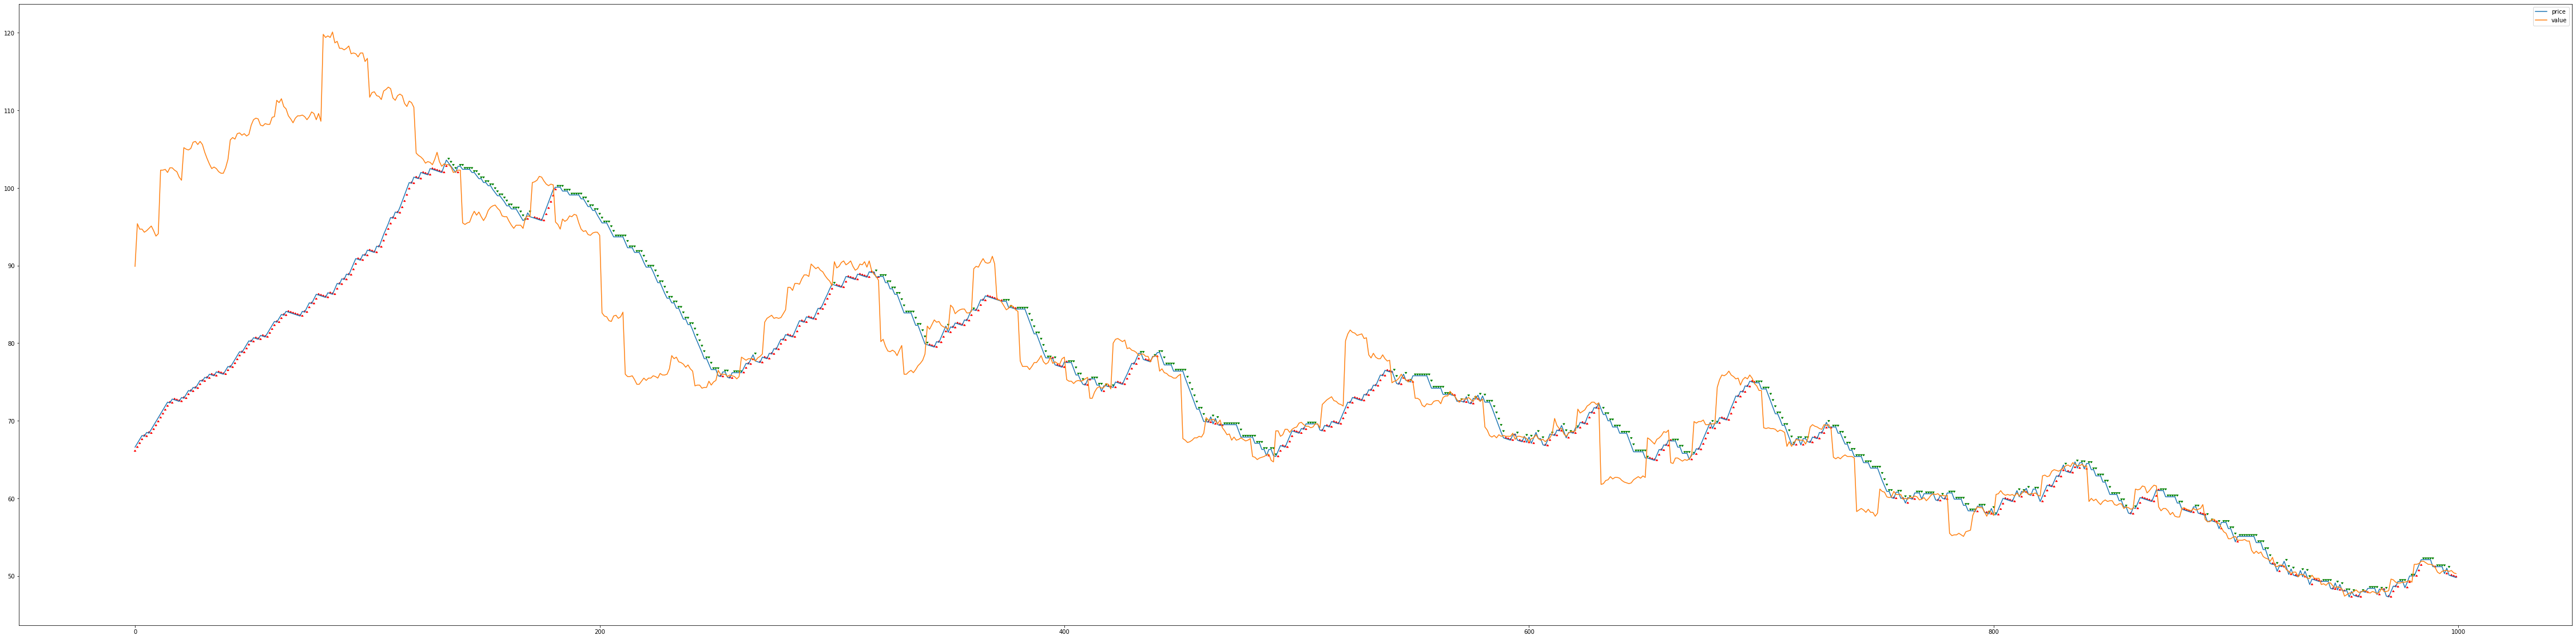

{'opt': 460, 'pes': 511, 'fud': 29}
opt: 0.46
pes: 0.511
fud: 0.029


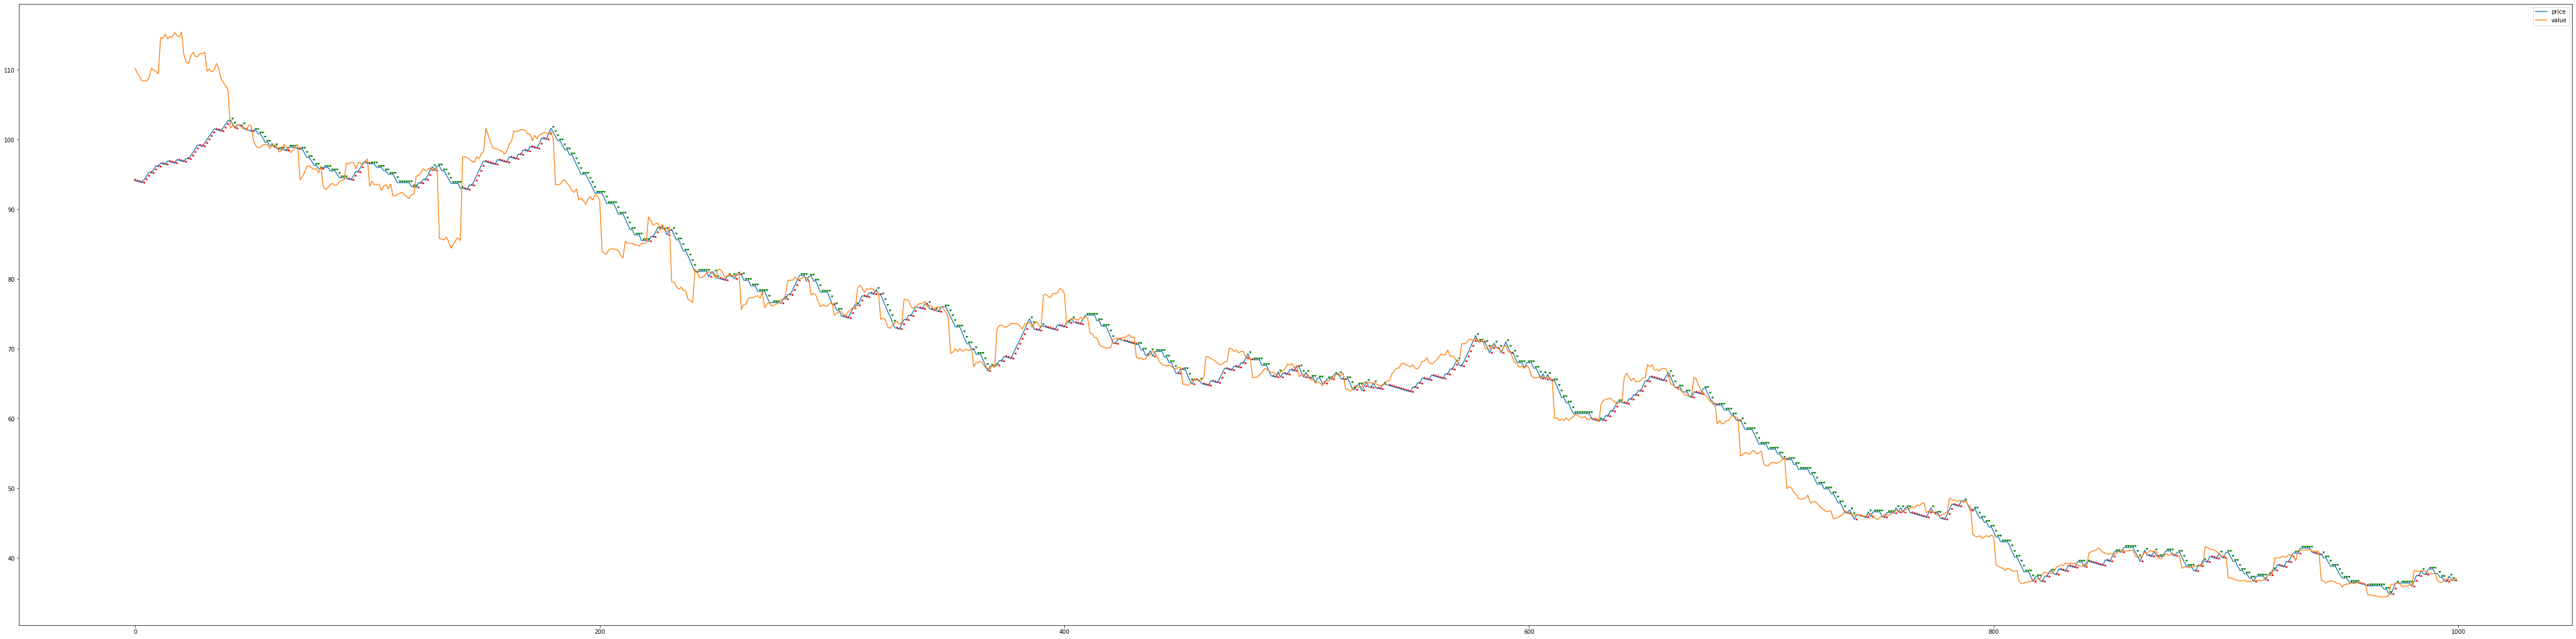

{'opt': 647, 'pes': 344, 'fud': 9}
opt: 0.647
pes: 0.344
fud: 0.009


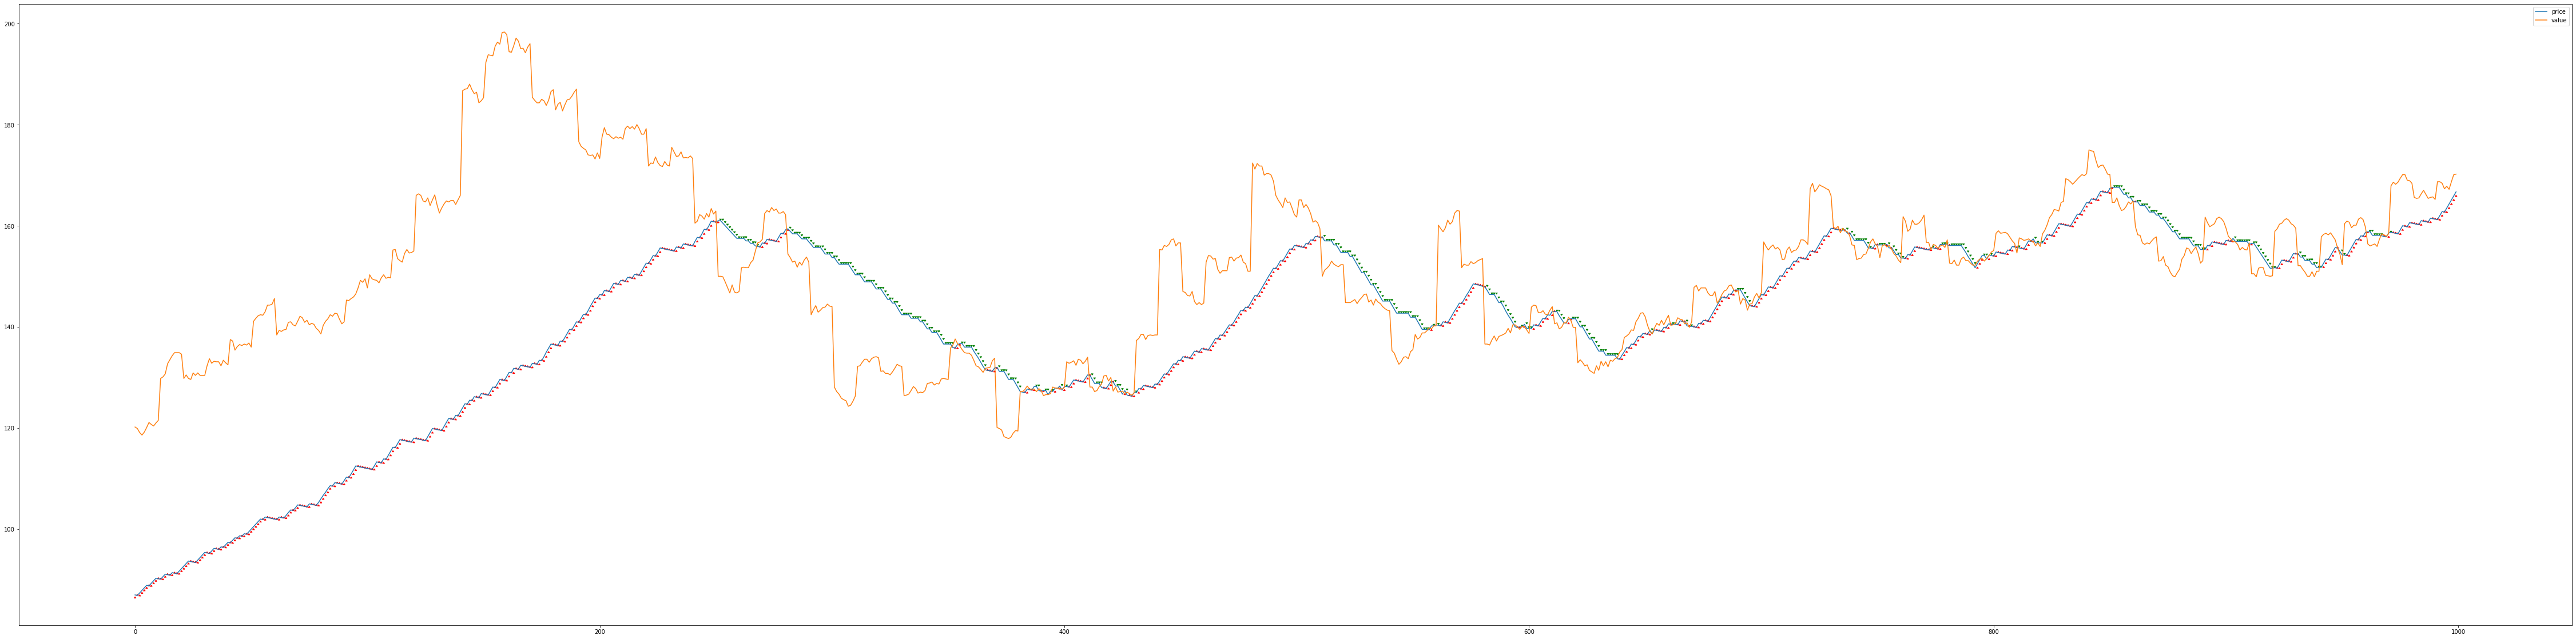

In [108]:
action_ref = {0: "opt", 1: "pes", 2: "fud"}
tick_ref = {i: tick for i, tick in zip(list(range(0, 9)), list(range(-4, 5)))}
print(agent_id)
for state, market in zip(rl_states, markets):
    orders = []
    counter = {"opt": 0, "pes": 0, "fud": 0}
    for i, action in enumerate(state[agent_id]['actions']):
        group = action_ref[action[0]]
        ticks = 1
        price = market['price'][249+i] + tick_size * ticks
        volume = 1
        order = {'time': i, "group": group, "price": price, "volume": volume}
        counter[group] += 1
        orders.append(order)

    total_actions = sum(counter.values())
    print(counter)
    print(f"opt: {counter['opt'] / total_actions}\npes: {counter['pes'] / total_actions}\nfud: {counter['fud'] / total_actions}")
    bid_x, bid_y = [], []
    ask_x, ask_y = [], []
    bid_sizes, ask_sizes = [], []
    bid_colors, ask_colors = [], []
    base_size = 10
    for i, order in enumerate(orders):
        if order['group'] == 'opt':
    #         if order['time'] > 5000 and order['time'] < 5100:
            bid_x.append(order['time'])
            bid_y.append(order['price'])
            bid_colors.append('r')
            bid_sizes.append(base_size * order['volume'])
        if order['group'] == 'pes':
    #         if order['time'] > 5000 and order['time'] < 5100:
            ask_x.append(order['time'])
            ask_y.append(order['price'])
            ask_colors.append('g')  
            ask_sizes.append(base_size * order['volume'])
    plot_price = market['price'][250:]
    plot_value = market['value'][250:]
    x = np.arange(len(plot_price))
    plt.figure(figsize=(80, 20))
    plt.plot(x, plot_price, label = "price")
    plt.plot(x, plot_value, label = "value")
    plt.legend()
    plt.scatter(bid_x, bid_y, s = bid_sizes, c = bid_colors, marker = 6)
    plt.scatter(ask_x, ask_y, s = ask_sizes, c = ask_colors, marker = 7)
    plt.show()
    

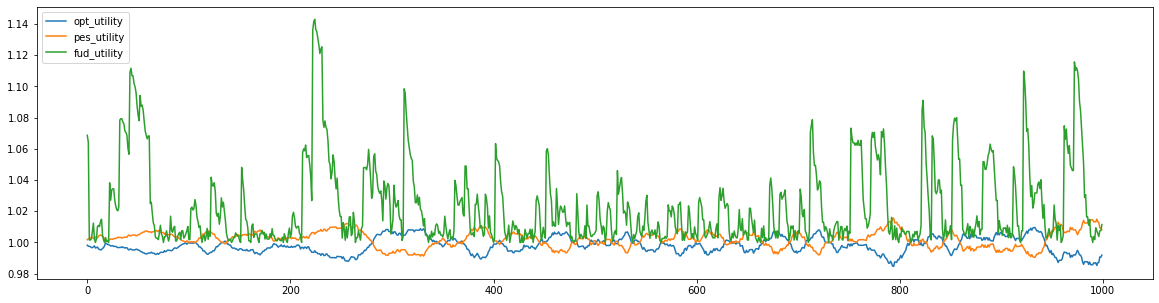

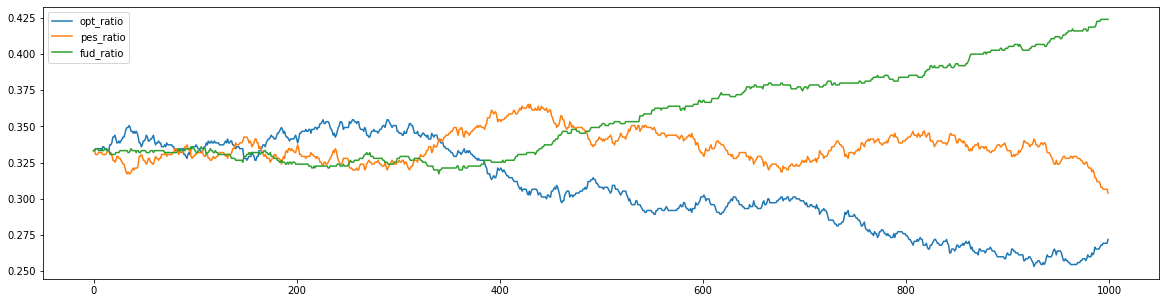

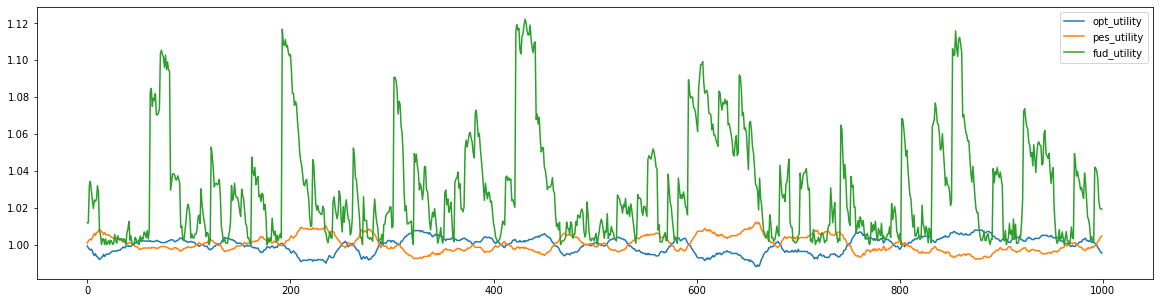

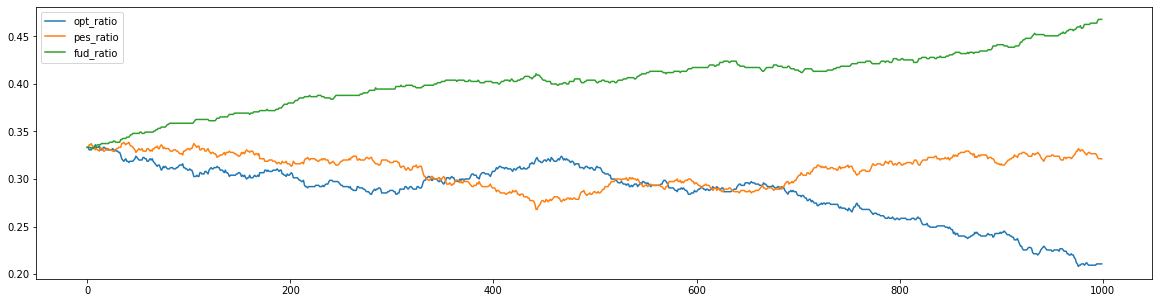

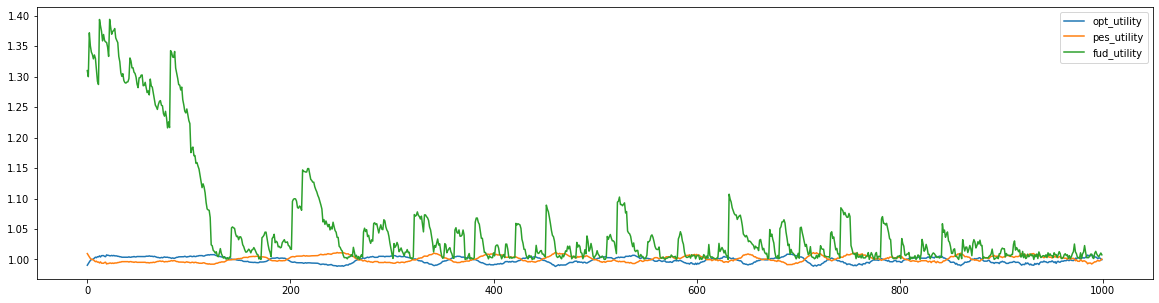

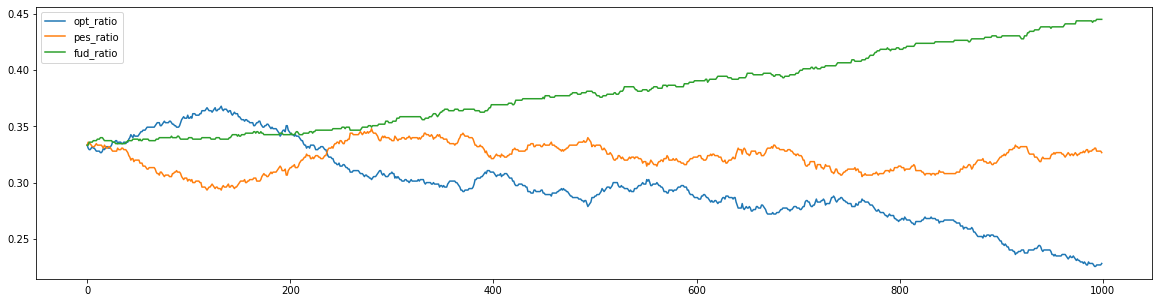

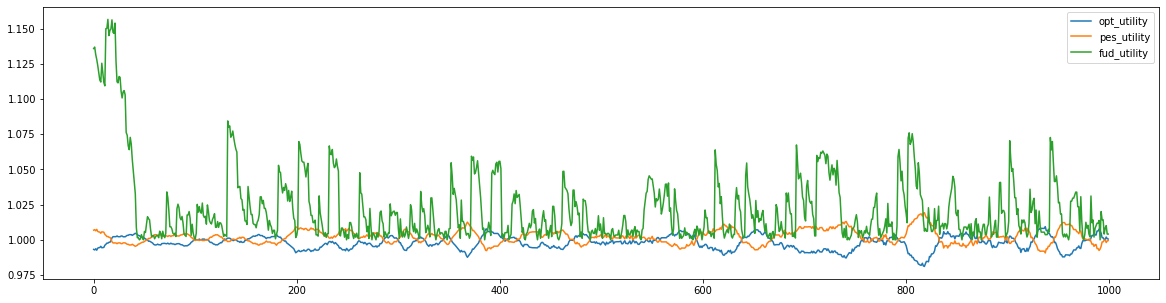

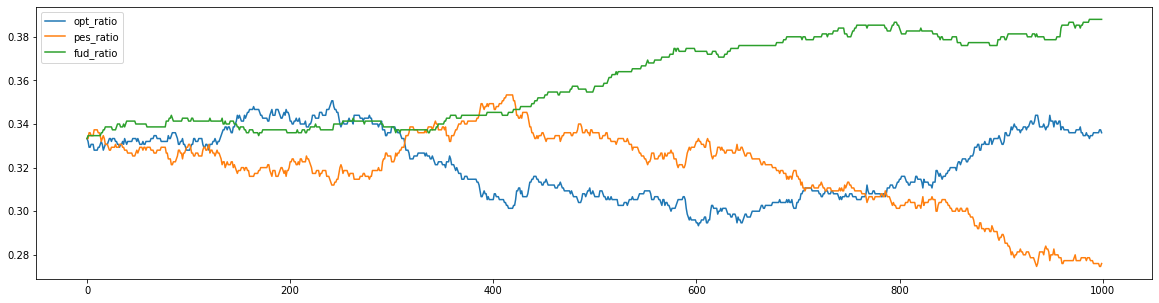

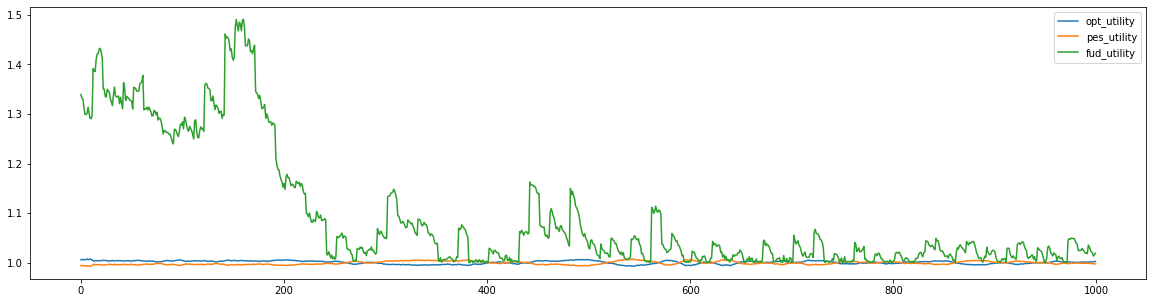

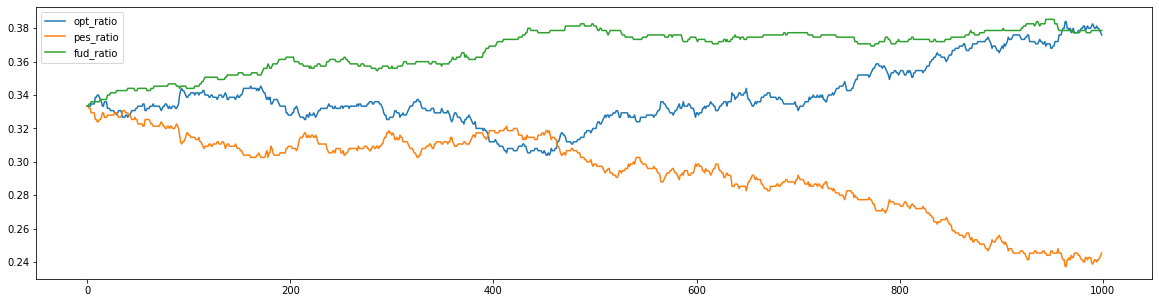

In [109]:
for rl_state in rl_states:
    for i, item in enumerate(['opt_utility', 'pes_utility', 'fud_utility']):
        l = [state['observations'][i] for state in rl_state[agent_id]['states']]
        plt.plot(l, label = item)
    plt.legend()
    plt.show()

    for i, item in enumerate(['opt_ratio', 'pes_ratio', 'fud_ratio']):
        l = [state['observations'][i+3] for state in rl_state[agent_id]['states']]
        plt.plot(l, label = item)
    plt.legend()
    plt.show()


## Agent

In [ ]:
agent = pd.read_json(agent_path)
group_names = agent.columns
num_of_timesteps = len(agent[group_names[0]]['cash'])

In [ ]:
# Holdings
for i, rl_state in enumerate(rl_states):
    agent_state = rl_state[agent_id]['states']
    cash = [state['cash'] for state in agent_state]
    holding = [state['TSMC'] for state in agent_state]
    wealth = [state['wealth'] for state in agent_state]
    plt.plot(wealth, label = f"sim_{i}")
    plt.legend()

In [ ]:
# Holdings
agent_state = rl_states[-1][agent_id]['states']
cash = [state['cash'] for state in agent_state]
holding = [state['TSMC'] for state in agent_state]
wealth = [state['wealth'] for state in agent_state]
plt.plot(cash, label = "Cash")
plt.plot(wealth, label = "Wealth")
plt.legend()
plt.show()
plt.plot(holding, label = "TSMC")
plt.legend()

### Holdings

#### Initial state

In [ ]:
num_agent = 0
total_cash, total_TSMC = 0, 0
zi_cash, zi_TSMC = 0, 0
for group_name in group_names:
    if 'dh' in group_name:
        continue
    elif 'zi' in group_name:
        zi_cash += sum(agent[group_name]['initial_cash_by_agent'])
        zi_TSMC += sum([i['TSMC'] for i in agent[group_name]['initial_security_by_agent']])
    else:
        total_cash += sum(agent[group_name]['initial_cash_by_agent'])
        total_TSMC += sum([i['TSMC'] for i in agent[group_name]['initial_security_by_agent']])
        num_agent += len(agent[group_name]['initial_cash_by_agent'])

print(f"Number of agents: {num_agent}")
print(f"Total TSMC: {total_TSMC} Total cash: {total_cash}")
print(f"Average TSMC: {total_TSMC // num_agent} Average cash: {total_cash // num_agent}")
print(f"ZI TSMC: {zi_TSMC} ZI cash: {zi_cash}")
if 'dh_1' in group_names:
    print(f"Dahoo cash: {agent['dh_1']['initial_cash_by_agent'][0]}")

#### Wealth

In [ ]:
# for agent_type in agent.columns:
for group_name in agent.columns:
    plt.figure(figsize=(20, 10))
    plt.plot(agent[group_name]['wealth'])
    plt.title(group_name)
    plt.show()

In [ ]:
# normalize 
wealth = np.array([agent[group_name]['wealth'] for group_name in group_names])
std_wealth = (wealth - wealth[:, 0].reshape(-1, 1)) / wealth[:, 0].reshape(-1, 1)

plt.figure(figsize=(30, 20))
for i, group_name in enumerate(agent.columns):
    plt.plot(std_wealth[i], label = group_names[i])
plt.legend()

#### Cash

In [ ]:
plt.figure(figsize=(30, 10))
for i, group_name in enumerate(agent.columns):
    plt.plot(agent[group_name]['cash'], label = group_names[i])
plt.legend()
plt.show()

#### Security

In [ ]:
plt.figure(figsize=(20, 10))
for i, group_name in enumerate(agent.columns):
    plt.plot(agent[group_name]['TSMC'], label = group_names[i])
plt.legend()
plt.show()

#### Portfolio

In [ ]:
plt.figure(figsize=(20, 10))

close_price = tsmc['close'].to_numpy()
for group_name in group_names:
    security_value = close_price * np.array(agent[group_name]['TSMC']) * 100
    security_propotion = security_value / (np.array(agent[group_name]['cash'])  + security_value)
    plt.plot(security_propotion)
    plt.title(group_name, size = 20)
    plt.show()

In [ ]:
# baseline_return = pow(1.01, 100) / 2
# for group_name in group_names:
#     plt.figure(figsize=(20, 10))
#     plt.axhline(y = baseline_return)
#     plt.scatter(agent[group_name]['initial_wealth_by_agent'], np.array(agent[group_name]['returns_by_agent']))
#     plt.xlabel('Initial wealth')
#     plt.ylabel('Return')
#     plt.title(f"{group_name}")
#     plt.show()

#### Average cost

In [ ]:
plt.figure(figsize=(20, 10))
for i, group_name in enumerate(agent.columns):
    plt.plot(agent[group_name]['average_cost'], label = group_names[i])
plt.legend()

### Orders

#### Number

#### Each group

In [ ]:
from collections import defaultdict

t = list(group_names)
for group_name in group_names:
    if 'zi' in group_name:
        continue
    bids_timestep, bids_price, bids_volume, asks_timestep, asks_price, asks_volume = [], [], [], [], [], []
    bids_price_volume = defaultdict(float)
    asks_price_volume = defaultdict(float)
    
    for i in range(len(agent[group_name]['timestep_bid'])):
        for price, volume in agent[group_name]['timestep_bid'][i].items():
            bids_timestep.append(i)
            bids_price.append(float(price))
            bids_volume.append(volume)
            bids_price_volume[float(price)] += volume
        for price, volume in agent[group_name]['timestep_ask'][i].items():
            asks_timestep.append(i)
            asks_price.append(float(price))
            asks_volume.append(volume)
            asks_price_volume[float(price)] += volume
    
    bids_size = [ 400*(volume - min(bids_volume)) / max(bids_volume) - min(bids_volume) for volume in bids_volume]
    asks_size = [ 400*(volume - min(asks_volume)) / max(asks_volume) - min(asks_volume) for volume in asks_volume]
    plt.plot(tsmc['close'])
    plt.scatter(bids_timestep, bids_price, s = bids_size, c = 'r', marker = 6)
    plt.scatter(asks_timestep, asks_price, s = asks_size, c = 'g', marker = 7)
    plt.title(group_name)
    plt.show()
    plt.bar(list(bids_price_volume.keys()), list(bids_price_volume.values()), color = 'r')
    plt.bar(list(asks_price_volume.keys()), np.array(list(asks_price_volume.values())) * -1, color = 'g')
    plt.show()


#### Propotion

In [ ]:
group_bids_volume = [agent.loc['group_bids_volume', group_name] for group_name in group_names]
group_bids_volume = np.array(group_bids_volume).T
group_bids_volume = group_bids_volume / group_bids_volume.sum(axis = 1).reshape(-1, 1)
for i in range(len(group_names)):
#     if group_names[i] == 'zi_1000':
#         continue
    plt.plot(group_bids_volume[:, i], label = group_names[i])
# plt.ylim(0, 0.1)
plt.legend()

In [ ]:
group_asks_volume = [agent.loc['group_asks_volume', group_name] for group_name in group_names]
group_asks_volume = np.array(group_asks_volume).T
group_asks_volume = group_asks_volume / group_asks_volume.sum(axis = 1).reshape(-1, 1)
for i in range(len(group_names)):
#     if group_names[i] == 'zi_1000':
#         continue
    plt.plot(-1 * group_asks_volume[:, i], label = group_names[i])

# plt.ylim(-0.3, 0.2)
plt.legend()

## RL Agent

In [ ]:
import random

markets, agents, rl_states, lengths, timesteps = [], [], [], [], []
for _dir in validate_dirs:
    record_dir = result_dir / 'validate' / _dir
    security_path = record_dir / "TSMC.json"
    agent_path = record_dir / "agent.json"
    rl_path = record_dir / 'rl_agent.json'
    config_path = result_dir / 'config.json'
    market = json.loads(security_path.read_text())
    markets.append(market)
    agents.append(json.loads(agent_path.read_text()))
    rl_states.append(json.loads(rl_path.read_text()))
    lengths.append(len(market['price']))
    timesteps.append([i for i in range(len(market['price']))])

In [ ]:
print(f"Average length: {sum(lengths) / len(lengths)}")

In [ ]:
for timestep, action in enumerate(actions):
    if action[0] == 0:
        bid_x.append(timestep + 100)
        bid_y.append(action[1]*0.1)
        bid_colors.append('r')
        bid_sizes.append(base_size * action[2])
    elif action[0] == 1:
        ask_x.append(timestep + 100)
        ask_y.append(action[1]*0.1)
        ask_colors.append('g')
        ask_sizes.append(base_size * action[2])

In [ ]:
for group in config['Agent']['RLAgent']:
    group_name = group['name']
    group_number = group['number']
    sample_id = f"{group_name}_{group_number}_{random.randint(0, group_number-1)}"
    state = rl_states[sample_id]
    print(sample_id)
    holdings_df = pd.DataFrame(rl_states[sample_id]['states'])
    plt.plot(holdings_df.wealth / holdings_df.wealth[0], label = "wealth")
    plt.plot(holdings_df.TSMC / holdings_df.TSMC[0], label = "TSMC")
    plt.plot(holdings_df.cash / holdings_df.cash[0], label = "cash")
    plt.legend()
    plt.show()
    
    actions = rl_states[sample_id]['actions']
    actions_df = pd.DataFrame(rl_states[sample_id]['actions'], columns = ['action', 'tick', 'volume'])
    print(f"Bid rate: {actions_df.action.eq(0).mean()}, Ask rate: {actions_df.action.eq(1).mean()}, Hold rate: {actions_df.action.eq(2).mean()}")
    bid_x, bid_y = [], []
    ask_x, ask_y = [], []
    bid_sizes, ask_sizes = [], []
    bid_colors, ask_colors = [], []
    base_size = 200
    for timestep, action in enumerate(actions):
        if action[0] == 0:
            bid_x.append(timestep + 100)
            bid_y.append(action[1]*0.1)
            bid_colors.append('r')
            bid_sizes.append(base_size * action[2])
        elif action[0] == 1:
            ask_x.append(timestep + 100)
            ask_y.append(action[1]*0.1)
            ask_colors.append('g')
            ask_sizes.append(base_size * action[2])
            
    x = np.arange(2500)
    plt.figure(figsize=(80, 20))
    plt.plot(x, market['price'][100:])
    plt.scatter(bid_x, a, s = bid_sizes, c = bid_colors, marker = 6)
    plt.scatter(ask_x, ask_y, s = ask_sizes, c = ask_colors, marker = 7)
    plt.show()

        
    break

### Relation of reward and performance

In [ ]:
agent_ids = list(rl_states.keys())
agent_id = random.sample(agent_ids, 1)
state = rl_states[agent_id]
rewards = state['rewards']


In [ ]:
plt.plot(timesteps, rewards, label = ['action', 'wealth', 'is_valid'])
plt.legend()

In [ ]:
sim_num = len(train_dirs)
length = len(market['price'][100:])
timesteps = [i for i in range(length)]
agent_ids = list(rl_states.keys())
agent_id = random.sample(agent_ids, 1)[0]

total_rewards = []
for i in range(sim_num):
    record_dir = result_dir / 'train' / f'sim_{i}'
#     security_path = record_dir / "TSMC.json"
#     agent_path = record_dir / "agent.json"
    rl_path = record_dir / 'rl_agent.json'
#     market = json.loads(security_path.read_text())
#     agents = json.loads(agent_path.read_text())
    rl_states = json.loads(rl_path.read_text())
    total_rewards.append(rl_states[agent_id]['rewards'])


In [ ]:
action_rewards = []
wealth_rewards = []
valid_rewards = []

tr = np.array(total_rewards)
total_reward_by_type = tr.reshape([-1, 3])

In [ ]:
plt.plot(total_reward_by_type, label = ['action', 'wealth', 'is_valid'])
plt.legend()

### Orders

In [ ]:
agents.keys()

In [ ]:
rl_states['ppo_tr_100_0']

### Distribution of actions along times from random agent

In [ ]:
prices = market['price'][100:]
bids = market['bid_five_price']
asks = market['ask_five_price']
bid_or_asks = []
agent_id = random.sample(agent_ids, 1)[0]
state = rl_states[agent_id]
counters = []
for agent_id, state in rl_states.items():
    bid_or_asks = []
    for i, action in enumerate(state['actions']):
        bid_or_ask = action[0]
        ticks = action[1]
        volume = action[2] + 1
        current_price = prices[i]
        tick_size = 0.1

        if bid_or_ask == 2:
            pass
        elif bid_or_ask == 0:
            # bid
            best_bids = list(bids[i])
            best_bid = current_price if len(best_bids) == 0 else float(best_bids[0])
            price = round(best_bid + (4-ticks) * tick_size, 2)

        elif bid_or_ask == 1:
            # ask
            best_asks = list(asks[i])
            best_ask = current_price if len(best_asks) == 0 else float(best_asks[0])
            price = round(best_ask + (ticks-4) * tick_size, 2)
        bid_or_asks.append(bid_or_ask)


    counter = {0: 0, 1: 0, 2: 0}
    for a in bid_or_asks:
        counter[a] += 1
    counters.append(counter)


In [ ]:
hold_times = {i: 0 for i in range(length+1)}
bid_times = {i: 0 for i in range(length+1)}
ask_times = {i: 0 for i in range(length+1)}

for counter in counters:
    bid_times[counter[0]] += 1
    ask_times[counter[1]] += 1
    hold_times[counter[2]] += 1
    

In [ ]:
plt.plot(timesteps, list(hold_times.values()), 'r')
plt.plot(timesteps, list(bid_times.values()), 'b')
plt.plot(timesteps, list(ask_times.values()), 'g')

In [ ]:
# append data for maintaining the same length
rl_states['states'][-1]['action'] = rl_states['states'][-2]['action']
rl_states['states'][-1]['reward'] = rl_states['states'][-2]['reward']

In [ ]:
rl_dict = {}
for k, v in rl_states['states'][0].items():
    if type(v) != dict:
        rl_dict[k] = []
    else:
        for key in v.keys():
            rl_dict[key] = []

In [ ]:
for state in rl_states['states']:
    for k, v in state.items():
        if type(v) != dict:
            rl_dict[k].append(v)
        else:
            for key, value in v.items():
                rl_dict[key].append(value)

In [ ]:
rl_df = pd.DataFrame(rl_dict)
rl_df

Reward

In [ ]:
plt.plot(rl_df.wealth / rl_df.wealth[0])
plt.plot(rl_df.wealth_reward)

Action

In [ ]:
'''
1. Discrete 3 - BUY[0], SELL[1], HOLD[2]
2. Discrete 9 - TICK_-4[0], TICK_-3[1], TICK_-2[2], TICK_-1[3], TICK_0[4], TICK_1[5], TICK_2[6], TICK_3[7], TICK_4[8]
3. Discrete 5 - VOLUME_1[0], VOLUME_2[1], VOLUME_3[2], VOLUME_4[3], VOLUME_5[4],
'''
valid_action_rate = rl_df.is_valid.mean()
bid_rate = rl_df.action.apply(lambda x: int(x[0]) == 0).mean()
ask_rate = rl_df.action.apply(lambda x: int(x[1]) == 0).mean()
hold_rate = rl_df.action.apply(lambda x: int(x[2]) == 0).mean()
print(f"Bid rate: {bid_rate}\nAsk rate: {ask_rate}\nHold rate: {hold_rate}\nValid action rate: {valid_action_rate}")

In [ ]:
rl_orders = rl_states['orders']

In [ ]:
bid_x, bid_y = [], []
ask_x, ask_y = [], []
bid_sizes, ask_sizes = [], []
bid_colors, ask_colors = [], []
base_size = 200
for order in rl_orders:
    if order['bid_or_ask'] == 'BID':
        if order['time'] > 5000 and order['time'] < 5100:
            bid_x.append(order['time'])
            bid_y.append(order['price'])
            bid_colors.append('r')
            bid_sizes.append(base_size * order['volume'])
    if order['bid_or_ask'] == 'ASK':
        if order['time'] > 5000 and order['time'] < 5100:
            ask_x.append(order['time'])
            ask_y.append(order['price'])
            ask_colors.append('g')  
            ask_sizes.append(base_size * order['volume'])

In [ ]:
x = np.arange(len(tsmc['close']))
plt.figure(figsize=(80, 20))
plt.plot(x[4999: 5101], tsmc['close'][4999:5101])
plt.scatter(bid_x, bid_y, s = bid_sizes, c = bid_colors, marker = 6)
plt.scatter(ask_x, ask_y, s = ask_sizes, c = ask_colors, marker = 7)
plt.show()